In [37]:
# imports data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


# Загрузка и подготовка датафрейма

In [38]:
# Загружаем инстанс и посмотрим на описание
iris = load_iris()

print('Ключи:\n\t', iris.keys())
print('Признаки:\n\t', iris.feature_names)
print('Таргет:\n\t', list(zip(iris.target_names, np.unique(iris.target) )))

Ключи:
	 dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])
Признаки:
	 ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Таргет:
	 [('setosa', 0), ('versicolor', 1), ('virginica', 2)]


In [39]:
y = iris.target

np.unique(y)

array([0, 1, 2])

In [40]:
# Загрузим данные в табличное представление
df = pd.concat([
                pd.DataFrame(iris.data, columns=iris.feature_names),
                pd.DataFrame(iris.target, columns=['target'])
                ],
                 axis=1
                )
df.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [41]:
# В данных оставляем только 2 класса: Iris Versicolor, Iris Virginica.
df = df[df['target'] != 0]
df.target.unique()

array([1, 2])

In [42]:
# Представим target в виде бинарной классификации 0 и 1 (Iris Versicolor, Iris Virginica.)
le = LabelEncoder()

le.fit(df.target)
df['target'] = le.fit_transform(df.target)
df.target.unique()

array([0, 1], dtype=int64)

In [43]:
df.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'target'],
      dtype='object')

In [44]:
# Переименуем колонки и посмотрим на подготовленные данные:
df = df.rename(columns={
                        'sepal length (cm)' : 'sepal_length','sepal width (cm)': 'sepal_width',
                        'petal length (cm)': 'petal_length', 'petal width (cm)': 'petal_width',})
df.head()

,sepal_length,sepal_width,petal_length,petal_width,target
50,7.0,3.2,4.7,1.4,0
51,6.4,3.2,4.5,1.5,0
52,6.9,3.1,4.9,1.5,0
53,5.5,2.3,4.0,1.3,0
54,6.5,2.8,4.6,1.5,0


In [45]:
df.shape

(100, 5)

In [46]:
X = df.drop('target', axis=1)
y = df['target']

In [47]:
# Нормализация данных
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [48]:
# Разобьем данные на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Для начала воспользуемся методом из библиотеки sklearn

In [49]:
model_sklearn = LogisticRegression()
model_sklearn.fit(X_train, y_train)

LogisticRegression()

In [50]:
model_sklearn.intercept_, model_sklearn.coef_

(array([0.04449619]),
 array([[-0.14179521, -0.76305971,  2.09626788,  2.09544343]]))

In [51]:
sklearn_pred = model_sklearn.predict(X_test)

In [52]:
#Посчитаем точность
(sklearn_pred == y_test).mean()

0.9

# Собственная реализация логистической регрессии с помощью градиентного спуска

In [82]:
class MyLogisticRegression:

    def __init__(self, LEARNING_RATE =0.005, max_epoches=2000000, fit_intercept=True, threshold=0.5, EPS= 5e-8, costs=[], gamma=0.9, costs_rms=[]):
        
        self.LEARNING_RATE = LEARNING_RATE
        self.max_epoches = max_epoches
        self.fit_intercept = fit_intercept
        self.threshold = threshold
        self.EPS = EPS
        self.gamma = gamma
        self.costs = costs
        self.costs_rms = costs_rms

   # Внутренние функции для реализации градиентного спуска
    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def __logg_loss(self, h, y):
        return (-y*np.log(h) - (1-y)*np.log(1-h)).mean()
    

    # Напишем метод градиентного спуска GD
    def fit_GD(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)

        # Инцализация весов. Размерность вектора совпадает с количеством признаков в матрице Х
        self.theta = np.zeros(X.shape[1])

        for epoch in range(self.max_epoches):
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / y.size
            self.theta -= self.LEARNING_RATE * gradient
            cost = self.__logg_loss(h, y)
            self.costs.append(cost)
  
            try:
                if abs(cost - self.costs[-2]) < self.EPS:
                    print('-'*60)
                    print(f'Модель обучилась за {epoch} эпох') 
                    print(f'Веса модели:{self.theta}')
                    print(f'Итоговая ошибка модели Entropy Log loss:  {cost}')
                    print('-'*60)
                    break
            except:
                pass 

    # Напишем метод оптимизации RMSprop     
    def fit_RMSprop(self, X, y):   
                
        if self.fit_intercept:
            X = self.__add_intercept(X)

        #Сгенерируем веса  
        self.theta  = np.zeros(X.shape[1])
        self.cache  = np.zeros(X.shape[1])
        
        for epoch in range(self.max_epoches):
            
            # Рассчитаем сигнал через функцию активации sigmoid 
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            
            # Вычислим кроэтропийную ошибку при текущих весах           
            loss = - np.mean(np.log(h) * y + np.log(1 - h) * (1 - y))
            self.costs_rms.append(loss)
            
            #  Вычислим градиент в сторону, которого мы будем делать шаг обучения    
            grad = np.dot(X.T, (h - y)) / y.size  
            
            # Обновим веса в сторону рассчитанного антиградиента
            self.cache = self.gamma * self.cache + (1 - self.gamma) * grad ** 2
            self.theta -= self.LEARNING_RATE * grad / (np.sqrt(self.cache) + 1e-8)
          
            #  Рассчитаем потерю logg loss на текущей эпохе обучения и запишем ее в список   
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            cost_rms = self.__logg_loss(h, y)
            self.costs.append(cost_rms)
            print(f' Эпоха обучения: {epoch} ---> log loss: {cost_rms}')
        
        #   Условие остановки, при котором будем считать, что модель обучилась.      
            try:
                if abs(cost_rms - self.costs_rms[-2]) < self.EPS:
                    print('-'*60)
                    print(f'Модель обучилась за {epoch} эпох') 
                    print(f'Веса модели:{self.cache}')
                    print(f'Итоговая ошибка модели Entropy Log loss:  {cost_rms}')
                    print('-'*60)
                    break
            except:
                pass 

    

    # Функции для оценки качества модели

    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)

        return self.__sigmoid(np.dot(X, self.theta))

    def predict(self, X, threshold=0.5):
        return self.predict_prob(X) >= threshold

    
    def accuracy_score(self, X):
        return (self.predict(X) == y).mean()


# Обучение и оценка качества модели

In [19]:
# Создаю инстанс собственного класса логистической регрессии

model_gd = MyLogisticRegression(LEARNING_RATE=1e-3, EPS= 1e-6)

In [20]:
# Посмотрим как падает ошибка в процессе градиентного спуска
model_gd.fit_GD(X_train, y_train)

------------------------------------------------------------
Модель обучилась за 44406 эпох
Веса модели:[ 0.04111118 -0.1089796  -0.89938285  2.32914941  2.5282901 ]
Итоговая ошибка модели Entropy Log loss:  0.07366717312742539
------------------------------------------------------------


In [21]:
loss_gd = model_gd.costs

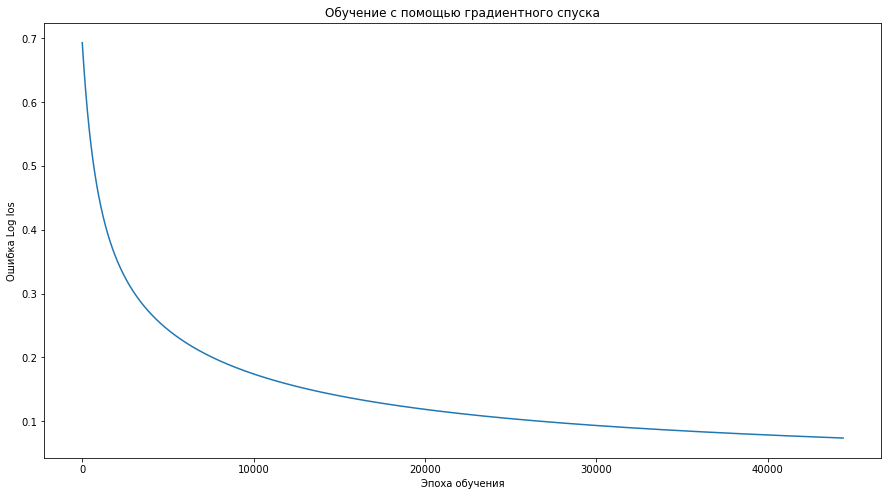

In [22]:
# Постриом график, как изменялась ошибка в процессе обучения модели
plt.figure(figsize= (15, 8))
plt.plot(loss_gd)
plt.title('Обучение с помощью градиентного спуска')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка Log los')
plt.show()

In [23]:
# Качество алгоритма
y_pred = model_gd.predict(X)
score = (y_pred == y).mean()
print(f'Метрика качества accuracy: {score}')

Метрика качества accuracy: 0.97


# RMS prop

In [83]:
model_RMSpro = MyLogisticRegression(LEARNING_RATE=1e-3, EPS= 1e-6)

In [84]:
model_RMSpro.fit_RMSprop(X_train, y_train)

 Эпоха обучения: 0 ---> log loss: 0.689208592564299
 Эпоха обучения: 1 ---> log loss: 0.6863841883701425
 Эпоха обучения: 2 ---> log loss: 0.6840386953847696
 Эпоха обучения: 3 ---> log loss: 0.6819707720951668
 Эпоха обучения: 4 ---> log loss: 0.680087092151805
 Эпоха обучения: 5 ---> log loss: 0.6783356973307594
 Эпоха обучения: 6 ---> log loss: 0.6766842937300861
 Эпоха обучения: 7 ---> log loss: 0.6751112704210129
 Эпоха обучения: 8 ---> log loss: 0.6736013772314395
 Эпоха обучения: 9 ---> log loss: 0.6721434141239097
 Эпоха обучения: 10 ---> log loss: 0.6707288958929505
 Эпоха обучения: 11 ---> log loss: 0.6693512325876606
 Эпоха обучения: 12 ---> log loss: 0.6680052016997868
 Эпоха обучения: 13 ---> log loss: 0.666686594618034
 Эпоха обучения: 14 ---> log loss: 0.6653919719160082
 Эпоха обучения: 15 ---> log loss: 0.6641184891968241
 Эпоха обучения: 16 ---> log loss: 0.6628637701564876
 Эпоха обучения: 17 ---> log loss: 0.6616258121249989
 Эпоха обучения: 18 ---> log loss: 0.6604

 Эпоха обучения: 184 ---> log loss: 0.5115929834520583
 Эпоха обучения: 185 ---> log loss: 0.5109038606916699
 Эпоха обучения: 186 ---> log loss: 0.5102168339496386
 Эпоха обучения: 187 ---> log loss: 0.5095320164359867
 Эпоха обучения: 188 ---> log loss: 0.5088493569931898
 Эпоха обучения: 189 ---> log loss: 0.5081683868847708
 Эпоха обучения: 190 ---> log loss: 0.5074895641902772
 Эпоха обучения: 191 ---> log loss: 0.5068129017958748
 Эпоха обучения: 192 ---> log loss: 0.5061383072473583
 Эпоха обучения: 193 ---> log loss: 0.5054657658947971
 Эпоха обучения: 194 ---> log loss: 0.504795268300667
 Эпоха обучения: 195 ---> log loss: 0.5041268087179221
 Эпоха обучения: 196 ---> log loss: 0.5034603804802787
 Эпоха обучения: 197 ---> log loss: 0.5027959777556242
 Эпоха обучения: 198 ---> log loss: 0.5021335940657451
 Эпоха обучения: 199 ---> log loss: 0.5014732234163929
 Эпоха обучения: 200 ---> log loss: 0.5008148592642732
 Эпоха обучения: 201 ---> log loss: 0.5001584955639914
 Эпоха обуч

 Эпоха обучения: 369 ---> log loss: 0.4089369930886925
 Эпоха обучения: 370 ---> log loss: 0.40847194671316733
 Эпоха обучения: 371 ---> log loss: 0.4080076952642934
 Эпоха обучения: 372 ---> log loss: 0.4075442428868775
 Эпоха обучения: 373 ---> log loss: 0.40708158278203155
 Эпоха обучения: 374 ---> log loss: 0.4066197190971206
 Эпоха обучения: 375 ---> log loss: 0.406158645034327
 Эпоха обучения: 376 ---> log loss: 0.40569836474505167
 Эпоха обучения: 377 ---> log loss: 0.4052388714335918
 Эпоха обучения: 378 ---> log loss: 0.404780169254783
 Эпоха обучения: 379 ---> log loss: 0.4043222514165039
 Эпоха обучения: 380 ---> log loss: 0.4038651220753429
 Эпоха обучения: 381 ---> log loss: 0.40340877444343426
 Эпоха обучения: 382 ---> log loss: 0.40295321267792333
 Эпоха обучения: 383 ---> log loss: 0.40249842999465574
 Эпоха обучения: 384 ---> log loss: 0.4020444305515456
 Эпоха обучения: 385 ---> log loss: 0.40159120756689826
 Эпоха обучения: 386 ---> log loss: 0.4011387652007626
 Эпох

 Эпоха обучения: 542 ---> log loss: 0.3392743154311993
 Эпоха обучения: 543 ---> log loss: 0.3389286614895759
 Эпоха обучения: 544 ---> log loss: 0.33858359810515176
 Эпоха обучения: 545 ---> log loss: 0.3382391186667652
 Эпоха обучения: 546 ---> log loss: 0.3378952275318586
 Эпоха обучения: 547 ---> log loss: 0.3375519180925901
 Эпоха обучения: 548 ---> log loss: 0.33720919470205973
 Эпоха обучения: 549 ---> log loss: 0.3368670507557215
 Эпоха обучения: 550 ---> log loss: 0.336525490601911
 Эпоха обучения: 551 ---> log loss: 0.33618450763934365
 Эпоха обучения: 552 ---> log loss: 0.33584410621114585
 Эпоха обучения: 553 ---> log loss: 0.3355042797192512
 Эпоха обучения: 554 ---> log loss: 0.3351650325011066
 Эпоха обучения: 555 ---> log loss: 0.33482635796180943
 Эпоха обучения: 556 ---> log loss: 0.33448826043263213
 Эпоха обучения: 557 ---> log loss: 0.33415073332176787
 Эпоха обучения: 558 ---> log loss: 0.33381378095378944
 Эпоха обучения: 559 ---> log loss: 0.3334773967399057
 Эп

 Эпоха обучения: 714 ---> log loss: 0.2871825408427811
 Эпоха обучения: 715 ---> log loss: 0.2869120194710135
 Эпоха обучения: 716 ---> log loss: 0.28664178551398833
 Эпоха обучения: 717 ---> log loss: 0.28637183557843526
 Эпоха обучения: 718 ---> log loss: 0.2861021726389241
 Эпоха обучения: 719 ---> log loss: 0.28583279327032224
 Эпоха обучения: 720 ---> log loss: 0.2855637004661259
 Эпоха обучения: 721 ---> log loss: 0.28529489076821435
 Эпоха обучения: 722 ---> log loss: 0.2850263671944186
 Эпоха обучения: 723 ---> log loss: 0.2847581262511412
 Эпоха обучения: 724 ---> log loss: 0.28449017098669954
 Эпоха обучения: 725 ---> log loss: 0.28422249786791154
 Эпоха обучения: 726 ---> log loss: 0.28395510998101553
 Эпоха обучения: 727 ---> log loss: 0.2836880037470779
 Эпоха обучения: 728 ---> log loss: 0.2834211822997573
 Эпоха обучения: 729 ---> log loss: 0.28315464200542045
 Эпоха обучения: 730 ---> log loss: 0.282888386057901
 Эпоха обучения: 731 ---> log loss: 0.28262241075593814
 Э

 Эпоха обучения: 886 ---> log loss: 0.24466166698506947
 Эпоха обучения: 887 ---> log loss: 0.24443686801866044
 Эпоха обучения: 888 ---> log loss: 0.2442123192115019
 Эпоха обучения: 889 ---> log loss: 0.24398801112989854
 Эпоха обучения: 890 ---> log loss: 0.24376395272902868
 Эпоха обучения: 891 ---> log loss: 0.24354013458411045
 Эпоха обучения: 892 ---> log loss: 0.24331656564128018
 Эпоха обучения: 893 ---> log loss: 0.24309323648547837
 Эпоха обучения: 894 ---> log loss: 0.24287015605288148
 Эпоха обучения: 895 ---> log loss: 0.242647314938928
 Эпоха обучения: 896 ---> log loss: 0.24242472206894955
 Эпоха обучения: 897 ---> log loss: 0.24220236804912715
 Эпоха обучения: 898 ---> log loss: 0.2419802617936653
 Эпоха обучения: 899 ---> log loss: 0.24175839391915122
 Эпоха обучения: 900 ---> log loss: 0.24153677332903822
 Эпоха обучения: 901 ---> log loss: 0.24131539064975413
 Эпоха обучения: 902 ---> log loss: 0.24109425477464227
 Эпоха обучения: 903 ---> log loss: 0.24087335633961

 Эпоха обучения: 1062 ---> log loss: 0.20866256657142943
 Эпоха обучения: 1063 ---> log loss: 0.20847718402699458
 Эпоха обучения: 1064 ---> log loss: 0.20829200509238827
 Эпоха обучения: 1065 ---> log loss: 0.20810702135738932
 Эпоха обучения: 1066 ---> log loss: 0.20792224053294586
 Эпоха обучения: 1067 ---> log loss: 0.20773765423929974
 Эпоха обучения: 1068 ---> log loss: 0.20755327014970804
 Эпоха обучения: 1069 ---> log loss: 0.2073690799173379
 Эпоха обучения: 1070 ---> log loss: 0.20718509117576978
 Эпоха обучения: 1071 ---> log loss: 0.2070012956137564
 Эпоха обучения: 1072 ---> log loss: 0.20681770082316508
 Эпоха обучения: 1073 ---> log loss: 0.2066342985311859
 Эпоха обучения: 1074 ---> log loss: 0.2064510962859064
 Эпоха обучения: 1075 ---> log loss: 0.20626808585597928
 Эпоха обучения: 1076 ---> log loss: 0.20608527474364557
 Эпоха обучения: 1077 ---> log loss: 0.2059026547621922
 Эпоха обучения: 1078 ---> log loss: 0.2057202333659803
 Эпоха обучения: 1079 ---> log loss: 

 Эпоха обучения: 1249 ---> log loss: 0.17716543792503345
 Эпоха обучения: 1250 ---> log loss: 0.17701289276549348
 Эпоха обучения: 1251 ---> log loss: 0.17686049682662683
 Эпоха обучения: 1252 ---> log loss: 0.17670826715168042
 Эпоха обучения: 1253 ---> log loss: 0.17655618640912538
 Эпоха обучения: 1254 ---> log loss: 0.1764042715810841
 Эпоха обучения: 1255 ---> log loss: 0.17625250529195421
 Эпоха обучения: 1256 ---> log loss: 0.17610090459824906
 Эпоха обучения: 1257 ---> log loss: 0.17594945200437512
 Эпоха обучения: 1258 ---> log loss: 0.17579816469941376
 Эпоха обучения: 1259 ---> log loss: 0.1756470250885098
 Эпоха обучения: 1260 ---> log loss: 0.17549605045218503
 Эпоха обучения: 1261 ---> log loss: 0.1753452231844668
 Эпоха обучения: 1262 ---> log loss: 0.17519456055699184
 Эпоха обучения: 1263 ---> log loss: 0.17504404504133564
 Эпоха обучения: 1264 ---> log loss: 0.17489369381319844
 Эпоха обучения: 1265 ---> log loss: 0.17474348945694346
 Эпоха обучения: 1266 ---> log los

 Эпоха обучения: 1416 ---> log loss: 0.15375465980836725
 Эпоха обучения: 1417 ---> log loss: 0.15362626344394584
 Эпоха обучения: 1418 ---> log loss: 0.15349800707244857
 Эпоха обучения: 1419 ---> log loss: 0.1533698745761257
 Эпоха обучения: 1420 ---> log loss: 0.15324188177858916
 Эпоха обучения: 1421 ---> log loss: 0.15311401257911747
 Эпоха обучения: 1422 ---> log loss: 0.15298628278484228
 Эпоха обучения: 1423 ---> log loss: 0.15285867631205677
 Эпоха обучения: 1424 ---> log loss: 0.15273120895142062
 Эпоха обучения: 1425 ---> log loss: 0.15260386463625097
 Эпоха обучения: 1426 ---> log loss: 0.15247665914072145
 Эпоха обучения: 1427 ---> log loss: 0.15234957641519287
 Эпоха обучения: 1428 ---> log loss: 0.1522226322173311
 Эпоха обучения: 1429 ---> log loss: 0.15209581051455348
 Эпоха обучения: 1430 ---> log loss: 0.1519691270480073
 Эпоха обучения: 1431 ---> log loss: 0.15184256580216274
 Эпоха обучения: 1432 ---> log loss: 0.1517161425016551
 Эпоха обучения: 1433 ---> log loss

 Эпоха обучения: 1596 ---> log loss: 0.13263962113485264
 Эпоха обучения: 1597 ---> log loss: 0.1325328100805414
 Эпоха обучения: 1598 ---> log loss: 0.1324261146789076
 Эпоха обучения: 1599 ---> log loss: 0.13231952031464989
 Эпоха обучения: 1600 ---> log loss: 0.1322130413562514
 Эпоха обучения: 1601 ---> log loss: 0.13210666320461273
 Эпоха обучения: 1602 ---> log loss: 0.1320004002125182
 Эпоха обучения: 1603 ---> log loss: 0.13189423779705745
 Эпоха обучения: 1604 ---> log loss: 0.1317881902953282
 Эпоха обучения: 1605 ---> log loss: 0.13168224314059604
 Эпоха обучения: 1606 ---> log loss: 0.13157641065428471
 Эпоха обучения: 1607 ---> log loss: 0.13147067828582237
 Эпоха обучения: 1608 ---> log loss: 0.13136506034097145
 Эпоха обучения: 1609 ---> log loss: 0.1312595422853095
 Эпоха обучения: 1610 ---> log loss: 0.1311541384089503
 Эпоха обучения: 1611 ---> log loss: 0.13104883419360733
 Эпоха обучения: 1612 ---> log loss: 0.13094364391375848
 Эпоха обучения: 1613 ---> log loss: 0

 Эпоха обучения: 1769 ---> log loss: 0.11567780054971047
 Эпоха обучения: 1770 ---> log loss: 0.11558807481309603
 Эпоха обучения: 1771 ---> log loss: 0.11549843200030148
 Эпоха обучения: 1772 ---> log loss: 0.11540888517991374
 Эпоха обучения: 1773 ---> log loss: 0.1153194210922793
 Эпоха обучения: 1774 ---> log loss: 0.11523005279151197
 Эпоха обучения: 1775 ---> log loss: 0.11514076703285905
 Эпоха обучения: 1776 ---> log loss: 0.11505157685597676
 Эпоха обучения: 1777 ---> log loss: 0.11496246903099674
 Эпоха обучения: 1778 ---> log loss: 0.1148734565831334
 Эпоха обучения: 1779 ---> log loss: 0.11478452629738636
 Эпоха обучения: 1780 ---> log loss: 0.11469569118454354
 Эпоха обучения: 1781 ---> log loss: 0.11460693804445633
 Эпоха обучения: 1782 ---> log loss: 0.11451827987350188
 Эпоха обучения: 1783 ---> log loss: 0.11442970348636712
 Эпоха обучения: 1784 ---> log loss: 0.11434122186503376
 Эпоха обучения: 1785 ---> log loss: 0.1142528218390078
 Эпоха обучения: 1786 ---> log los

 Эпоха обучения: 1947 ---> log loss: 0.10102861637025212
 Эпоха обучения: 1948 ---> log loss: 0.1009533562639033
 Эпоха обучения: 1949 ---> log loss: 0.1008781636643492
 Эпоха обучения: 1950 ---> log loss: 0.10080305041441202
 Эпоха обучения: 1951 ---> log loss: 0.10072800451527725
 Эпоха обучения: 1952 ---> log loss: 0.10065303779672072
 Эпоха обучения: 1953 ---> log loss: 0.10057813827333423
 Эпоха обучения: 1954 ---> log loss: 0.10050331776186365
 Эпоха обучения: 1955 ---> log loss: 0.1004285642902903
 Эпоха обучения: 1956 ---> log loss: 0.10035388966234604
 Эпоха обучения: 1957 ---> log loss: 0.10027928191938477
 Эпоха обучения: 1958 ---> log loss: 0.10020475285214078
 Эпоха обучения: 1959 ---> log loss: 0.10013029051532336
 Эпоха обучения: 1960 ---> log loss: 0.10005590668668544
 Эпоха обучения: 1961 ---> log loss: 0.09998158943427497
 Эпоха обучения: 1962 ---> log loss: 0.09990735052287968
 Эпоха обучения: 1963 ---> log loss: 0.09983317803386918
 Эпоха обучения: 1964 ---> log los

 Эпоха обучения: 2124 ---> log loss: 0.0887810327700685
 Эпоха обучения: 2125 ---> log loss: 0.08871758429774104
 Эпоха обучения: 2126 ---> log loss: 0.08865420166021082
 Эпоха обучения: 2127 ---> log loss: 0.08859087397411629
 Эпоха обучения: 2128 ---> log loss: 0.08852761198412616
 Эпоха обучения: 2129 ---> log loss: 0.08846440481881775
 Эпоха обучения: 2130 ---> log loss: 0.08840126321123451
 Эпоха обучения: 2131 ---> log loss: 0.08833817630187625
 Эпоха обучения: 2132 ---> log loss: 0.08827515481217689
 Эпоха обучения: 2133 ---> log loss: 0.08821218789454263
 Эпоха обучения: 2134 ---> log loss: 0.08814928625881309
 Эпоха обучения: 2135 ---> log loss: 0.08808643906928484
 Эпоха обучения: 2136 ---> log loss: 0.08802365702421888
 Эпоха обучения: 2137 ---> log loss: 0.08796092929978565
 Эпоха обучения: 2138 ---> log loss: 0.08789826658268315
 Эпоха обучения: 2139 ---> log loss: 0.0878356580609396
 Эпоха обучения: 2140 ---> log loss: 0.08777311440970556
 Эпоха обучения: 2141 ---> log lo

 Эпоха обучения: 2305 ---> log loss: 0.07822027576722775
 Эпоха обучения: 2306 ---> log loss: 0.07816675792089793
 Эпоха обучения: 2307 ---> log loss: 0.07811328473396424
 Эпоха обучения: 2308 ---> log loss: 0.07805986596559743
 Эпоха обучения: 2309 ---> log loss: 0.07800649175410712
 Эпоха обучения: 2310 ---> log loss: 0.07795317184838495
 Эпоха обучения: 2311 ---> log loss: 0.0778998963972618
 Эпоха обучения: 2312 ---> log loss: 0.07784667513936443
 Эпоха обучения: 2313 ---> log loss: 0.07779349823402999
 Эпоха обучения: 2314 ---> log loss: 0.0777403754096347
 Эпоха обучения: 2315 ---> log loss: 0.07768729683600717
 Эпоха обучения: 2316 ---> log loss: 0.07763427223128726
 Эпоха обучения: 2317 ---> log loss: 0.07758129177578021
 Эпоха обучения: 2318 ---> log loss: 0.07752836517740393
 Эпоха обучения: 2319 ---> log loss: 0.07747548262692554
 Эпоха обучения: 2320 ---> log loss: 0.0774226538220549
 Эпоха обучения: 2321 ---> log loss: 0.07736986896400631
 Эпоха обучения: 2322 ---> log los

 Эпоха обучения: 2478 ---> log loss: 0.06965518768884163
 Эпоха обучения: 2479 ---> log loss: 0.06960948887544464
 Эпоха обучения: 2480 ---> log loss: 0.06956383565961748
 Эпоха обучения: 2481 ---> log loss: 0.0695182190320323
 Эпоха обучения: 2482 ---> log loss: 0.06947264790924959
 Эпоха обучения: 2483 ---> log loss: 0.0694271132912504
 Эпоха обучения: 2484 ---> log loss: 0.06938162408549645
 Эпоха обучения: 2485 ---> log loss: 0.06933617130126458
 Эпоха обучения: 2486 ---> log loss: 0.0692907638369307
 Эпоха обучения: 2487 ---> log loss: 0.06924539271105389
 Эпоха обучения: 2488 ---> log loss: 0.06920006681293711
 Эпоха обучения: 2489 ---> log loss: 0.06915477717040851
 Эпоха обучения: 2490 ---> log loss: 0.06910953266371088
 Эпоха обучения: 2491 ---> log loss: 0.06906432432992816
 Эпоха обучения: 2492 ---> log loss: 0.06901916104025567
 Эпоха обучения: 2493 ---> log loss: 0.06897403384101995
 Эпоха обучения: 2494 ---> log loss: 0.06892895159438162
 Эпоха обучения: 2495 ---> log los

 Эпоха обучения: 2657 ---> log loss: 0.06209105148237575
 Эпоха обучения: 2658 ---> log loss: 0.06205205921916396
 Эпоха обучения: 2659 ---> log loss: 0.0620130968369178
 Эпоха обучения: 2660 ---> log loss: 0.06197417249075366
 Эпоха обучения: 2661 ---> log loss: 0.061935277957902636
 Эпоха обучения: 2662 ---> log loss: 0.06189642138545857
 Эпоха обучения: 2663 ---> log loss: 0.061857594558834175
 Эпоха обучения: 2664 ---> log loss: 0.06181880561711208
 Эпоха обучения: 2665 ---> log loss: 0.06178004635387479
 Эпоха обучения: 2666 ---> log loss: 0.06174132490020527
 Эпоха обучения: 2667 ---> log loss: 0.06170263305784395
 Эпоха обучения: 2668 ---> log loss: 0.06166397894988545
 Эпоха обучения: 2669 ---> log loss: 0.06162535438621642
 Эпоха обучения: 2670 ---> log loss: 0.06158676748195441
 Эпоха обучения: 2671 ---> log loss: 0.06154821005512077
 Эпоха обучения: 2672 ---> log loss: 0.06150969021286715
 Эпоха обучения: 2673 ---> log loss: 0.06147119978133785
 Эпоха обучения: 2674 ---> log

 Эпоха обучения: 2825 ---> log loss: 0.05599006827403413
 Эпоха обучения: 2826 ---> log loss: 0.055956311336711195
 Эпоха обучения: 2827 ---> log loss: 0.05592257911712179
 Эпоха обучения: 2828 ---> log loss: 0.055888879134526885
 Эпоха обучения: 2829 ---> log loss: 0.0558552038141187
 Эпоха обучения: 2830 ---> log loss: 0.055821560668033406
 Эпоха обучения: 2831 ---> log loss: 0.055787942128717856
 Эпоха обучения: 2832 ---> log loss: 0.05575435570119335
 Эпоха обучения: 2833 ---> log loss: 0.05572079382515114
 Эпоха обучения: 2834 ---> log loss: 0.0556872639985077
 Эпоха обучения: 2835 ---> log loss: 0.055653758668188315
 Эпоха обучения: 2836 ---> log loss: 0.05562028532501456
 Эпоха обучения: 2837 ---> log loss: 0.055586836423135444
 Эпоха обучения: 2838 ---> log loss: 0.055553419446287784
 Эпоха обучения: 2839 ---> log loss: 0.05552002685583389
 Эпоха обучения: 2840 ---> log loss: 0.0554866661284358
 Эпоха обучения: 2841 ---> log loss: 0.05545332973265889
 Эпоха обучения: 2842 ---> 

 Эпоха обучения: 2998 ---> log loss: 0.050549789874104446
 Эпоха обучения: 2999 ---> log loss: 0.05052054562600704
 Эпоха обучения: 3000 ---> log loss: 0.05049132870425067
 Эпоха обучения: 3001 ---> log loss: 0.05046213212172553
 Эпоха обучения: 3002 ---> log loss: 0.0504329628137719
 Эпоха обучения: 3003 ---> log loss: 0.050403813799701686
 Эпоха обучения: 3004 ---> log loss: 0.05037469200854763
 Эпоха обучения: 3005 ---> log loss: 0.050345590466034436
 Эпоха обучения: 3006 ---> log loss: 0.05031651609489621
 Эпоха обучения: 3007 ---> log loss: 0.050287461927261204
 Эпоха обучения: 3008 ---> log loss: 0.05025843487957357
 Эпоха обучения: 3009 ---> log loss: 0.05022942799035629
 Эпоха обучения: 3010 ---> log loss: 0.050200448169772344
 Эпоха обучения: 3011 ---> log loss: 0.0501714884627303
 Эпоха обучения: 3012 ---> log loss: 0.0501425557731208
 Эпоха обучения: 3013 ---> log loss: 0.050113643152228965
 Эпоха обучения: 3014 ---> log loss: 0.05008475749768179
 Эпоха обучения: 3015 ---> l

 Эпоха обучения: 3169 ---> log loss: 0.04587690112629138
 Эпоха обучения: 3170 ---> log loss: 0.04585140571855205
 Эпоха обучения: 3171 ---> log loss: 0.04582592714737971
 Эпоха обучения: 3172 ---> log loss: 0.0458004718419847
 Эпоха обучения: 3173 ---> log loss: 0.04577503333590896
 Эпоха обучения: 3174 ---> log loss: 0.04574961805275389
 Эпоха обучения: 3175 ---> log loss: 0.04572421953175618
 Эпоха обучения: 3176 ---> log loss: 0.045698844190915945
 Эпоха обучения: 3177 ---> log loss: 0.04567348557515671
 Эпоха обучения: 3178 ---> log loss: 0.045648150096885026
 Эпоха обучения: 3179 ---> log loss: 0.045622831306703485
 Эпоха обучения: 3180 ---> log loss: 0.04559753561143255
 Эпоха обучения: 3181 ---> log loss: 0.04557225656734605
 Эпоха обучения: 3182 ---> log loss: 0.04554700057568612
 Эпоха обучения: 3183 ---> log loss: 0.04552176119838989
 Эпоха обучения: 3184 ---> log loss: 0.0454965448311288
 Эпоха обучения: 3185 ---> log loss: 0.04547134504149545
 Эпоха обучения: 3186 ---> log

 Эпоха обучения: 3339 ---> log loss: 0.04181519415892208
 Эпоха обучения: 3340 ---> log loss: 0.04179283836394103
 Эпоха обучения: 3341 ---> log loss: 0.04177049652655229
 Эпоха обучения: 3342 ---> log loss: 0.04174817462540489
 Эпоха обучения: 3343 ---> log loss: 0.041725866651211814
 Эпоха обучения: 3344 ---> log loss: 0.04170357857762266
 Эпоха обучения: 3345 ---> log loss: 0.04168130440041982
 Эпоха обучения: 3346 ---> log loss: 0.04165905008826027
 Эпоха обучения: 3347 ---> log loss: 0.04163680964198893
 Эпоха обучения: 3348 ---> log loss: 0.04161458902527683
 Эпоха обучения: 3349 ---> log loss: 0.04159238224402464
 Эпоха обучения: 3350 ---> log loss: 0.041570195256924014
 Эпоха обучения: 3351 ---> log loss: 0.04154802207492451
 Эпоха обучения: 3352 ---> log loss: 0.041525868651745144
 Эпоха обучения: 3353 ---> log loss: 0.0415037290033776
 Эпоха обучения: 3354 ---> log loss: 0.04148160907857482
 Эпоха обучения: 3355 ---> log loss: 0.04145950289836371
 Эпоха обучения: 3356 ---> lo

 Эпоха обучения: 3512 ---> log loss: 0.03818622292242749
 Эпоха обучения: 3513 ---> log loss: 0.03816656564905549
 Эпоха обучения: 3514 ---> log loss: 0.038146925510396446
 Эпоха обучения: 3515 ---> log loss: 0.03812729690923371
 Эпоха обучения: 3516 ---> log loss: 0.03810768541314153
 Эпоха обучения: 3517 ---> log loss: 0.03808808542942373
 Эпоха обучения: 3518 ---> log loss: 0.03806850252119708
 Эпоха обучения: 3519 ---> log loss: 0.0380489311002799
 Эпоха обучения: 3520 ---> log loss: 0.03802937672533727
 Эпоха обучения: 3521 ---> log loss: 0.03800983381269618
 Эпоха обучения: 3522 ---> log loss: 0.03799030791657573
 Эпоха обучения: 3523 ---> log loss: 0.03797079345780561
 Эпоха обучения: 3524 ---> log loss: 0.037951295986164764
 Эпоха обучения: 3525 ---> log loss: 0.0379318099269797
 Эпоха обучения: 3526 ---> log loss: 0.037912340825594935
 Эпоха обучения: 3527 ---> log loss: 0.03789288311182789
 Эпоха обучения: 3528 ---> log loss: 0.03787344232659447
 Эпоха обучения: 3529 ---> log

 Эпоха обучения: 3685 ---> log loss: 0.03498803900428089
 Эпоха обучения: 3686 ---> log loss: 0.03497067389241958
 Эпоха обучения: 3687 ---> log loss: 0.034953318352995734
 Эпоха обучения: 3688 ---> log loss: 0.03493597759041045
 Эпоха обучения: 3689 ---> log loss: 0.03491864637958772
 Эпоха обучения: 3690 ---> log loss: 0.03490132992093431
 Эпоха обучения: 3691 ---> log loss: 0.0348840229934151
 Эпоха обучения: 3692 ---> log loss: 0.03486673079344762
 Эпоха обучения: 3693 ---> log loss: 0.03484944810403252
 Эпоха обучения: 3694 ---> log loss: 0.034832180117603
 Эпоха обучения: 3695 ---> log loss: 0.0348149216211904
 Эпоха обучения: 3696 ---> log loss: 0.034797677803248654
 Эпоха обучения: 3697 ---> log loss: 0.03478044345483472
 Эпоха обучения: 3698 ---> log loss: 0.0347632237604281
 Эпоха обучения: 3699 ---> log loss: 0.034746013515106346
 Эпоха обучения: 3700 ---> log loss: 0.03472881789937958
 Эпоха обучения: 3701 ---> log loss: 0.03471163171234076
 Эпоха обучения: 3702 ---> log lo

 Эпоха обучения: 3861 ---> log loss: 0.03210945462556123
 Эпоха обучения: 3862 ---> log loss: 0.03209406894368474
 Эпоха обучения: 3863 ---> log loss: 0.03207869118192405
 Эпоха обучения: 3864 ---> log loss: 0.03206332621139763
 Эпоха обучения: 3865 ---> log loss: 0.03204796914402445
 Эпоха обучения: 3866 ---> log loss: 0.032032624847336974
 Эпоха обучения: 3867 ---> log loss: 0.03201728843687812
 Эпоха обучения: 3868 ---> log loss: 0.03200196477659867
 Эпоха обучения: 3869 ---> log loss: 0.031986648985661115
 Эпоха обучения: 3870 ---> log loss: 0.03197134592443879
 Эпоха обучения: 3871 ---> log loss: 0.031956050715709415
 Эпоха обучения: 3872 ---> log loss: 0.03194076821627315
 Эпоха обучения: 3873 ---> log loss: 0.031925493552518586
 Эпоха обучения: 3874 ---> log loss: 0.031910231577677
 Эпоха обучения: 3875 ---> log loss: 0.03189497742174355
 Эпоха обучения: 3876 ---> log loss: 0.031879735934384756
 Эпоха обучения: 3877 ---> log loss: 0.031864502249198005
 Эпоха обучения: 3878 ---> 

 Эпоха обучения: 4039 ---> log loss: 0.02952551423114749
 Эпоха обучения: 4040 ---> log loss: 0.029511833644051074
 Эпоха обучения: 4041 ---> log loss: 0.029498159606547572
 Эпоха обучения: 4042 ---> log loss: 0.029484496686575344
 Эпоха обучения: 4043 ---> log loss: 0.029470840302289667
 Эпоха обучения: 4044 ---> log loss: 0.029457195018396595
 Эпоха обучения: 4045 ---> log loss: 0.029443556256314476
 Эпоха обучения: 4046 ---> log loss: 0.02942992857752086
 Эпоха обучения: 4047 ---> log loss: 0.029416307406693442
 Эпоха обучения: 4048 ---> log loss: 0.029402697302084883
 Эпоха обучения: 4049 ---> log loss: 0.02938909369162855
 Эпоха обучения: 4050 ---> log loss: 0.029375501130355794
 Эпоха обучения: 4051 ---> log loss: 0.029361915049451952
 Эпоха обучения: 4052 ---> log loss: 0.029348340000730732
 Эпоха обучения: 4053 ---> log loss: 0.02933477141862573
 Эпоха обучения: 4054 ---> log loss: 0.02932121385173665
 Эпоха обучения: 4055 ---> log loss: 0.029307662737741564
 Эпоха обучения: 40

 Эпоха обучения: 4213 ---> log loss: 0.02727149778207273
 Эпоха обучения: 4214 ---> log loss: 0.027259244711294147
 Эпоха обучения: 4215 ---> log loss: 0.02724699708858363
 Эпоха обучения: 4216 ---> log loss: 0.02723475921373397
 Эпоха обучения: 4217 ---> log loss: 0.02722252677548299
 Эпоха обучения: 4218 ---> log loss: 0.027210304070687204
 Эпоха обучения: 4219 ---> log loss: 0.027198086791045895
 Эпоха обучения: 4220 ---> log loss: 0.027185879230482594
 Эпоха обучения: 4221 ---> log loss: 0.027173677083654823
 Эпоха обучения: 4222 ---> log loss: 0.027161484641556176
 Эпоха обучения: 4223 ---> log loss: 0.02714929760179924
 Эпоха обучения: 4224 ---> log loss: 0.0271371202524508
 Эпоха обучения: 4225 ---> log loss: 0.027124948294075416
 Эпоха обучения: 4226 ---> log loss: 0.027112786011816162
 Эпоха обучения: 4227 ---> log loss: 0.027100629109186244
 Эпоха обучения: 4228 ---> log loss: 0.027088481868408253
 Эпоха обучения: 4229 ---> log loss: 0.027076339995940942
 Эпоха обучения: 4230

 Эпоха обучения: 4380 ---> log loss: 0.025325687328978424
 Эпоха обучения: 4381 ---> log loss: 0.025314616760884076
 Эпоха обучения: 4382 ---> log loss: 0.025303554836080152
 Эпоха обучения: 4383 ---> log loss: 0.025292497478716845
 Эпоха обучения: 4384 ---> log loss: 0.025281448752392778
 Эпоха обучения: 4385 ---> log loss: 0.025270404583972398
 Эпоха обучения: 4386 ---> log loss: 0.02525936903436376
 Эпоха обучения: 4387 ---> log loss: 0.025248338033142657
 Эпоха обучения: 4388 ---> log loss: 0.0252373156385293
 Эпоха обучения: 4389 ---> log loss: 0.02522629778280823
 Эпоха обучения: 4390 ---> log loss: 0.02521528852151434
 Эпоха обучения: 4391 ---> log loss: 0.025204283789638193
 Эпоха обучения: 4392 ---> log loss: 0.0251932876400322
 Эпоха обучения: 4393 ---> log loss: 0.025182296010390036
 Эпоха обучения: 4394 ---> log loss: 0.025171312950884355
 Эпоха обучения: 4395 ---> log loss: 0.025160334401909307
 Эпоха обучения: 4396 ---> log loss: 0.02514936441096039
 Эпоха обучения: 4397 

 Эпоха обучения: 4549 ---> log loss: 0.02354460318600311
 Эпоха обучения: 4550 ---> log loss: 0.02353457810561476
 Эпоха обучения: 4551 ---> log loss: 0.02352455685987377
 Эпоха обучения: 4552 ---> log loss: 0.023514543295374276
 Эпоха обучения: 4553 ---> log loss: 0.023504533557579678
 Эпоха обучения: 4554 ---> log loss: 0.02349453149060532
 Эпоха обучения: 4555 ---> log loss: 0.0234845332424106
 Эпоха обучения: 4556 ---> log loss: 0.023474542654634303
 Эпоха обучения: 4557 ---> log loss: 0.02346455587772961
 Эпоха обучения: 4558 ---> log loss: 0.02345457675086113
 Эпоха обучения: 4559 ---> log loss: 0.023444601426973254
 Эпоха обучения: 4560 ---> log loss: 0.023434633742758768
 Эпоха обучения: 4561 ---> log loss: 0.023424669853651024
 Эпоха обучения: 4562 ---> log loss: 0.023414713593873336
 Эпоха обучения: 4563 ---> log loss: 0.023404761121345517
 Эпоха обучения: 4564 ---> log loss: 0.02339481626782371
 Эпоха обучения: 4565 ---> log loss: 0.023384875193712
 Эпоха обучения: 4566 --->

 Эпоха обучения: 4723 ---> log loss: 0.021882971475323348
 Эпоха обучения: 4724 ---> log loss: 0.021873883296921914
 Эпоха обучения: 4725 ---> log loss: 0.021864798322581442
 Эпоха обучения: 4726 ---> log loss: 0.021855720191573336
 Эпоха обучения: 4727 ---> log loss: 0.02184664525804335
 Эпоха обучения: 4728 ---> log loss: 0.021837577158973144
 Эпоха обучения: 4729 ---> log loss: 0.021828512250812372
 Эпоха обучения: 4730 ---> log loss: 0.02181945416825496
 Эпоха обучения: 4731 ---> log loss: 0.021810399270052364
 Эпоха обучения: 4732 ---> log loss: 0.02180135118861276
 Эпоха обучения: 4733 ---> log loss: 0.021792306284987396
 Эпоха обучения: 4734 ---> log loss: 0.021783268189300813
 Эпоха обучения: 4735 ---> log loss: 0.021774233264901945
 Эпоха обучения: 4736 ---> log loss: 0.021765205139633554
 Эпоха обучения: 4737 ---> log loss: 0.021756180179140373
 Эпоха обучения: 4738 ---> log loss: 0.02174716200898545
 Эпоха обучения: 4739 ---> log loss: 0.021738146997107136
 Эпоха обучения: 4

 Эпоха обучения: 4896 ---> log loss: 0.020382187040384667
 Эпоха обучения: 4897 ---> log loss: 0.02037391209416868
 Эпоха обучения: 4898 ---> log loss: 0.02036564328378093
 Эпоха обучения: 4899 ---> log loss: 0.02035737715436119
 Эпоха обучения: 4900 ---> log loss: 0.020349117153163877
 Эпоха обучения: 4901 ---> log loss: 0.0203408598274687
 Эпоха обучения: 4902 ---> log loss: 0.020332608622403592
 Эпоха обучения: 4903 ---> log loss: 0.020324360087386365
 Эпоха обучения: 4904 ---> log loss: 0.02031611766542015
 Эпоха обучения: 4905 ---> log loss: 0.020307877908059116
 Эпоха обучения: 4906 ---> log loss: 0.020299644256183413
 Эпоха обучения: 4907 ---> log loss: 0.02029141326348175
 Эпоха обучения: 4908 ---> log loss: 0.020283188368713043
 Эпоха обучения: 4909 ---> log loss: 0.020274966127698756
 Эпоха обучения: 4910 ---> log loss: 0.020266749977078252
 Эпоха обучения: 4911 ---> log loss: 0.020258536474804138
 Эпоха обучения: 4912 ---> log loss: 0.02025032905539789
 Эпоха обучения: 4913 

 Эпоха обучения: 5062 ---> log loss: 0.019066724346709196
 Эпоха обучения: 5063 ---> log loss: 0.019059138910965747
 Эпоха обучения: 5064 ---> log loss: 0.0190515590227792
 Эпоха обучения: 5065 ---> log loss: 0.019043981399122657
 Эпоха обучения: 5066 ---> log loss: 0.019036409316435632
 Эпоха обучения: 5067 ---> log loss: 0.01902883949369326
 Эпоха обучения: 5068 ---> log loss: 0.019021275205344218
 Эпоха обучения: 5069 ---> log loss: 0.019013713172364152
 Эпоха обучения: 5070 ---> log loss: 0.01900615666721237
 Эпоха обучения: 5071 ---> log loss: 0.01899860241286351
 Эпоха обучения: 5072 ---> log loss: 0.018991053679789077
 Эпоха обучения: 5073 ---> log loss: 0.018983507192961102
 Эпоха обучения: 5074 ---> log loss: 0.01897596622086481
 Эпоха обучения: 5075 ---> log loss: 0.018968427490468096
 Эпоха обучения: 5076 ---> log loss: 0.018960894268271404
 Эпоха обучения: 5077 ---> log loss: 0.018953363283237
 Эпоха обучения: 5078 ---> log loss: 0.018945837799882032
 Эпоха обучения: 5079 -

 Эпоха обучения: 5233 ---> log loss: 0.017824342809638377
 Эпоха обучения: 5234 ---> log loss: 0.01781738851070441
 Эпоха обучения: 5235 ---> log loss: 0.01781043611896869
 Эпоха обучения: 5236 ---> log loss: 0.01780348874688113
 Эпоха обучения: 5237 ---> log loss: 0.017796543278154737
 Эпоха обучения: 5238 ---> log loss: 0.017789602823370512
 Эпоха обучения: 5239 ---> log loss: 0.017782664268118316
 Эпоха обучения: 5240 ---> log loss: 0.017775730721111684
 Эпоха обучения: 5241 ---> log loss: 0.017768799069815953
 Эпоха обучения: 5242 ---> log loss: 0.017761872421078472
 Эпоха обучения: 5243 ---> log loss: 0.017754947664238706
 Эпоха обучения: 5244 ---> log loss: 0.017748027904279158
 Эпоха обучения: 5245 ---> log loss: 0.017741110032412105
 Эпоха обучения: 5246 ---> log loss: 0.01773419715175655
 Эпоха обучения: 5247 ---> log loss: 0.017727286155396177
 Эпоха обучения: 5248 ---> log loss: 0.017720380144587822
 Эпоха обучения: 5249 ---> log loss: 0.017713476014285214
 Эпоха обучения: 5

 Эпоха обучения: 5406 ---> log loss: 0.016670715475257947
 Эпоха обучения: 5407 ---> log loss: 0.01666432530779943
 Эпоха обучения: 5408 ---> log loss: 0.016657939701504004
 Эпоха обучения: 5409 ---> log loss: 0.016651555696706295
 Эпоха обучения: 5410 ---> log loss: 0.016645176248101922
 Эпоха обучения: 5411 ---> log loss: 0.016638798397791928
 Эпоха обучения: 5412 ---> log loss: 0.016632425098713335
 Эпоха обучения: 5413 ---> log loss: 0.01662605339473237
 Эпоха обучения: 5414 ---> log loss: 0.016619686237028655
 Эпоха обучения: 5415 ---> log loss: 0.01661332067123248
 Эпоха обучения: 5416 ---> log loss: 0.016606959646767165
 Эпоха обучения: 5417 ---> log loss: 0.016600600211025846
 Эпоха обучения: 5418 ---> log loss: 0.016594245311676786
 Эпоха обучения: 5419 ---> log loss: 0.01658789199787471
 Эпоха обучения: 5420 ---> log loss: 0.016581543215534077
 Эпоха обучения: 5421 ---> log loss: 0.01657519601557002
 Эпоха обучения: 5422 ---> log loss: 0.016568853342144228
 Эпоха обучения: 54

 Эпоха обучения: 5585 ---> log loss: 0.015574258472142378
 Эпоха обучения: 5586 ---> log loss: 0.01556839048979818
 Эпоха обучения: 5587 ---> log loss: 0.015562523848174248
 Эпоха обучения: 5588 ---> log loss: 0.015556661349941622
 Эпоха обучения: 5589 ---> log loss: 0.015550800189761255
 Эпоха обучения: 5590 ---> log loss: 0.01554494316864575
 Эпоха обучения: 5591 ---> log loss: 0.015539087482919932
 Эпоха обучения: 5592 ---> log loss: 0.015533235931939069
 Эпоха обучения: 5593 ---> log loss: 0.015527385713690722
 Эпоха обучения: 5594 ---> log loss: 0.015521539625873885
 Эпоха обучения: 5595 ---> log loss: 0.015515694868137902
 Эпоха обучения: 5596 ---> log loss: 0.015509854236526465
 Эпоха обучения: 5597 ---> log loss: 0.015504014932349592
 Эпоха обучения: 5598 ---> log loss: 0.015498179749996772
 Эпоха обучения: 5599 ---> log loss: 0.015492345892437635
 Эпоха обучения: 5600 ---> log loss: 0.015486516152408576
 Эпоха обучения: 5601 ---> log loss: 0.015480687734537651
 Эпоха обучения:

 Эпоха обучения: 5761 ---> log loss: 0.014582107094969352
 Эпоха обучения: 5762 ---> log loss: 0.014576696196633062
 Эпоха обучения: 5763 ---> log loss: 0.014571286423864398
 Эпоха обучения: 5764 ---> log loss: 0.014565880437325204
 Эпоха обучения: 5765 ---> log loss: 0.0145604755741231
 Эпоха обучения: 5766 ---> log loss: 0.014555074493350334
 Эпоха обучения: 5767 ---> log loss: 0.014549674533688602
 Эпоха обучения: 5768 ---> log loss: 0.014544278352661573
 Эпоха обучения: 5769 ---> log loss: 0.014538883290524019
 Эпоха обучения: 5770 ---> log loss: 0.014533492003231951
 Эпоха обучения: 5771 ---> log loss: 0.014528101832612293
 Эпоха обучения: 5772 ---> log loss: 0.01452271543305444
 Эпоха обучения: 5773 ---> log loss: 0.014517330147956411
 Эпоха обучения: 5774 ---> log loss: 0.014511948630141824
 Эпоха обучения: 5775 ---> log loss: 0.014506568224579021
 Эпоха обучения: 5776 ---> log loss: 0.014501191582526806
 Эпоха обучения: 5777 ---> log loss: 0.014495816050522694
 Эпоха обучения: 

 Эпоха обучения: 5943 ---> log loss: 0.013636231312217736
 Эпоха обучения: 5944 ---> log loss: 0.013631243852893335
 Эпоха обучения: 5945 ---> log loss: 0.01362625733352912
 Эпоха обучения: 5946 ---> log loss: 0.013621274275761866
 Эпоха обучения: 5947 ---> log loss: 0.013616292156098195
 Эпоха обучения: 5948 ---> log loss: 0.01361131349468854
 Эпоха обучения: 5949 ---> log loss: 0.013606335769529597
 Эпоха обучения: 5950 ---> log loss: 0.013601361499286353
 Эпоха обучения: 5951 ---> log loss: 0.013596388163444679
 Эпоха обучения: 5952 ---> log loss: 0.013591418279184931
 Эпоха обучения: 5953 ---> log loss: 0.01358644932748129
 Эпоха обучения: 5954 ---> log loss: 0.013581483824030457
 Эпоха обучения: 5955 ---> log loss: 0.013576519251293986
 Эпоха обучения: 5956 ---> log loss: 0.013571558123485658
 Эпоха обучения: 5957 ---> log loss: 0.013566597924553706
 Эпоха обучения: 5958 ---> log loss: 0.013561641167229818
 Эпоха обучения: 5959 ---> log loss: 0.013556685336947937
 Эпоха обучения: 

 Эпоха обучения: 6117 ---> log loss: 0.012800354657124683
 Эпоха обучения: 6118 ---> log loss: 0.012795731528308513
 Эпоха обучения: 6119 ---> log loss: 0.0127911091910697
 Эпоха обучения: 6120 ---> log loss: 0.012786490040907067
 Эпоха обучения: 6121 ---> log loss: 0.012781871680761732
 Эпоха обучения: 6122 ---> log loss: 0.012777256504718957
 Эпоха обучения: 6123 ---> log loss: 0.012772642117136484
 Эпоха обучения: 6124 ---> log loss: 0.012768030910686895
 Эпоха обучения: 6125 ---> log loss: 0.012763420491143757
 Эпоха обучения: 6126 ---> log loss: 0.012758813249767686
 Эпоха обучения: 6127 ---> log loss: 0.012754206793747298
 Эпоха обучения: 6128 ---> log loss: 0.012749603512932075
 Эпоха обучения: 6129 ---> log loss: 0.012745001015924842
 Эпоха обучения: 6130 ---> log loss: 0.012740401691164773
 Эпоха обучения: 6131 ---> log loss: 0.012735803148668061
 Эпоха обучения: 6132 ---> log loss: 0.012731207775464397
 Эпоха обучения: 6133 ---> log loss: 0.012726613182982566
 Эпоха обучения:

 Эпоха обучения: 6286 ---> log loss: 0.012046327722100047
 Эпоха обучения: 6287 ---> log loss: 0.012042024309579083
 Эпоха обучения: 6288 ---> log loss: 0.012037723847326024
 Эпоха обучения: 6289 ---> log loss: 0.012033424054522228
 Эпоха обучения: 6290 ---> log loss: 0.012029127209317574
 Эпоха обучения: 6291 ---> log loss: 0.012024831032244422
 Эпоха обучения: 6292 ---> log loss: 0.012020537800105048
 Эпоха обучения: 6293 ---> log loss: 0.012016245234782013
 Эпоха обучения: 6294 ---> log loss: 0.012011955611730725
 Эпоха обучения: 6295 ---> log loss: 0.012007666654183208
 Эпоха обучения: 6296 ---> log loss: 0.01200338063624877
 Эпоха обучения: 6297 ---> log loss: 0.01199909528250817
 Эпоха обучения: 6298 ---> log loss: 0.01199481286572526
 Эпоха обучения: 6299 ---> log loss: 0.011990531111828873
 Эпоха обучения: 6300 ---> log loss: 0.011986252292238165
 Эпоха обучения: 6301 ---> log loss: 0.011981974134229134
 Эпоха обучения: 6302 ---> log loss: 0.011977698907877164
 Эпоха обучения: 

 Эпоха обучения: 6457 ---> log loss: 0.011336060484155015
 Эпоха обучения: 6458 ---> log loss: 0.01133205381780757
 Эпоха обучения: 6459 ---> log loss: 0.011328047717697876
 Эпоха обучения: 6460 ---> log loss: 0.011324044350042826
 Эпоха обучения: 6461 ---> log loss: 0.011320041547511282
 Эпоха обучения: 6462 ---> log loss: 0.011316041475034129
 Эпоха обучения: 6463 ---> log loss: 0.011312041966568449
 Эпоха обучения: 6464 ---> log loss: 0.011308045185759797
 Эпоха обучения: 6465 ---> log loss: 0.011304048967852752
 Эпоха обучения: 6466 ---> log loss: 0.011300055475208244
 Эпоха обучения: 6467 ---> log loss: 0.011296062544357702
 Эпоха обучения: 6468 ---> log loss: 0.011292072336378115
 Эпоха обучения: 6469 ---> log loss: 0.011288082689086968
 Эпоха обучения: 6470 ---> log loss: 0.011284095762278058
 Эпоха обучения: 6471 ---> log loss: 0.011280109395054298
 Эпоха обучения: 6472 ---> log loss: 0.011276125745926924
 Эпоха обучения: 6473 ---> log loss: 0.011272142655283512
 Эпоха обучения

 Эпоха обучения: 6638 ---> log loss: 0.010636805943376298
 Эпоха обучения: 6639 ---> log loss: 0.01063308313218287
 Эпоха обучения: 6640 ---> log loss: 0.010629362848453078
 Эпоха обучения: 6641 ---> log loss: 0.010625643038022336
 Эпоха обучения: 6642 ---> log loss: 0.010621925752896725
 Эпоха обучения: 6643 ---> log loss: 0.010618208940138223
 Эпоха обучения: 6644 ---> log loss: 0.010614494650528848
 Эпоха обучения: 6645 ---> log loss: 0.010610780832356446
 Эпоха обучения: 6646 ---> log loss: 0.010607069535179684
 Эпоха обучения: 6647 ---> log loss: 0.010603358708511545
 Эпоха обучения: 6648 ---> log loss: 0.010599650400688023
 Эпоха обучения: 6649 ---> log loss: 0.010595942562446647
 Эпоха обучения: 6650 ---> log loss: 0.010592237240901286
 Эпоха обучения: 6651 ---> log loss: 0.01058853238801343
 Эпоха обучения: 6652 ---> log loss: 0.010584830049675505
 Эпоха обучения: 6653 ---> log loss: 0.010581128179072181
 Эпоха обучения: 6654 ---> log loss: 0.01057742882087517
 Эпоха обучения: 

 Эпоха обучения: 6824 ---> log loss: 0.009969486044948638
 Эпоха обучения: 6825 ---> log loss: 0.009966029621449782
 Эпоха обучения: 6826 ---> log loss: 0.009962575534812234
 Эпоха обучения: 6827 ---> log loss: 0.009959121842149806
 Эпоха обучения: 6828 ---> log loss: 0.009955670484405217
 Эпоха обучения: 6829 ---> log loss: 0.009952219519858613
 Эпоха обучения: 6830 ---> log loss: 0.009948770888288456
 Эпоха обучения: 6831 ---> log loss: 0.009945322649140774
 Эпоха обучения: 6832 ---> log loss: 0.009941876741030295
 Эпоха обучения: 6833 ---> log loss: 0.009938431224568231
 Эпоха обучения: 6834 ---> log loss: 0.009934988037206242
 Эпоха обучения: 6835 ---> log loss: 0.009931545240720143
 Эпоха обучения: 6836 ---> log loss: 0.009928104771399143
 Эпоха обучения: 6837 ---> log loss: 0.009924664692183033
 Эпоха обучения: 6838 ---> log loss: 0.009921226938199138
 Эпоха обучения: 6839 ---> log loss: 0.009917789573550592
 Эпоха обучения: 6840 ---> log loss: 0.00991435453220356
 Эпоха обучения

 Эпоха обучения: 7001 ---> log loss: 0.00937845455993822
 Эпоха обучения: 7002 ---> log loss: 0.009375230596170167
 Эпоха обучения: 7003 ---> log loss: 0.009372006963476051
 Эпоха обучения: 7004 ---> log loss: 0.009368785502692118
 Эпоха обучения: 7005 ---> log loss: 0.009365564372327459
 Эпоха обучения: 7006 ---> log loss: 0.009362345412107663
 Эпоха обучения: 7007 ---> log loss: 0.009359126781653761
 Эпоха обучения: 7008 ---> log loss: 0.0093559103195813
 Эпоха обучения: 7009 ---> log loss: 0.009352694186622572
 Эпоха обучения: 7010 ---> log loss: 0.009349480220283726
 Эпоха обучения: 7011 ---> log loss: 0.009346266582407758
 Эпоха обучения: 7012 ---> log loss: 0.00934305510939193
 Эпоха обучения: 7013 ---> log loss: 0.009339843964189465
 Эпоха обучения: 7014 ---> log loss: 0.009336634982089245
 Эпоха обучения: 7015 ---> log loss: 0.009333426327154027
 Эпоха обучения: 7016 ---> log loss: 0.009330219833565074
 Эпоха обучения: 7017 ---> log loss: 0.009327013666494076
 Эпоха обучения: 7

 Эпоха обучения: 7176 ---> log loss: 0.008832724326060684
 Эпоха обучения: 7177 ---> log loss: 0.008829709668799875
 Эпоха обучения: 7178 ---> log loss: 0.008826697036568115
 Эпоха обучения: 7179 ---> log loss: 0.008823684682407448
 Эпоха обучения: 7180 ---> log loss: 0.00882067435166307
 Эпоха обучения: 7181 ---> log loss: 0.00881766429843805
 Эпоха обучения: 7182 ---> log loss: 0.008814656267018177
 Эпоха обучения: 7183 ---> log loss: 0.008811648512566973
 Эпоха обучения: 7184 ---> log loss: 0.008808642778311447
 Эпоха обучения: 7185 ---> log loss: 0.008805637320474983
 Эпоха обучения: 7186 ---> log loss: 0.008802633881226323
 Эпоха обучения: 7187 ---> log loss: 0.008799630717848225
 Эпоха обучения: 7188 ---> log loss: 0.008796629571451681
 Эпоха обучения: 7189 ---> log loss: 0.008793628700378227
 Эпоха обучения: 7190 ---> log loss: 0.008790629844681753
 Эпоха обучения: 7191 ---> log loss: 0.008787631263761933
 Эпоха обучения: 7192 ---> log loss: 0.008784634696616138
 Эпоха обучения:

 Эпоха обучения: 7357 ---> log loss: 0.008305399000630721
 Эпоха обучения: 7358 ---> log loss: 0.008302585147386429
 Эпоха обучения: 7359 ---> log loss: 0.008299771526609248
 Эпоха обучения: 7360 ---> log loss: 0.008296959790547991
 Эпоха обучения: 7361 ---> log loss: 0.008294148286490572
 Эпоха обучения: 7362 ---> log loss: 0.008291338665676566
 Эпоха обучения: 7363 ---> log loss: 0.008288529276404034
 Эпоха обучения: 7364 ---> log loss: 0.008285721768903855
 Эпоха обучения: 7365 ---> log loss: 0.008282914492483657
 Эпоха обучения: 7366 ---> log loss: 0.00828010909636621
 Эпоха обучения: 7367 ---> log loss: 0.008277303930868172
 Эпоха обучения: 7368 ---> log loss: 0.008274500644204714
 Эпоха обучения: 7369 ---> log loss: 0.008271697587700936
 Эпоха обучения: 7370 ---> log loss: 0.008268896408565039
 Эпоха обучения: 7371 ---> log loss: 0.008266095459130013
 Эпоха обучения: 7372 ---> log loss: 0.008263296385597585
 Эпоха обучения: 7373 ---> log loss: 0.00826049754130808
 Эпоха обучения:

 Эпоха обучения: 7538 ---> log loss: 0.007812809249968841
 Эпоха обучения: 7539 ---> log loss: 0.007810178650577342
 Эпоха обучения: 7540 ---> log loss: 0.007807549808936877
 Эпоха обучения: 7541 ---> log loss: 0.007804921161081107
 Эпоха обучения: 7542 ---> log loss: 0.007802294269626259
 Эпоха обучения: 7543 ---> log loss: 0.0077996675715679
 Эпоха обучения: 7544 ---> log loss: 0.007797042628561696
 Эпоха обучения: 7545 ---> log loss: 0.007794417878564428
 Эпоха обучения: 7546 ---> log loss: 0.007791794882271787
 Эпоха обучения: 7547 ---> log loss: 0.0077891720786013524
 Эпоха обучения: 7548 ---> log loss: 0.007786551027289322
 Эпоха обучения: 7549 ---> log loss: 0.007783930168213474
 Эпоха обучения: 7550 ---> log loss: 0.00778131106015107
 Эпоха обучения: 7551 ---> log loss: 0.007778692143939603
 Эпоха обучения: 7552 ---> log loss: 0.0077760749773978875
 Эпоха обучения: 7553 ---> log loss: 0.007773458002322588
 Эпоха обучения: 7554 ---> log loss: 0.007770842775574625
 Эпоха обучения

 Эпоха обучения: 7729 ---> log loss: 0.007327662379830402
 Эпоха обучения: 7730 ---> log loss: 0.007325211321294562
 Эпоха обучения: 7731 ---> log loss: 0.0073227604228300195
 Эпоха обучения: 7732 ---> log loss: 0.007320311158110139
 Эпоха обучения: 7733 ---> log loss: 0.007317862053138757
 Эпоха обучения: 7734 ---> log loss: 0.00731541458067745
 Эпоха обучения: 7735 ---> log loss: 0.007312967267642461
 Эпоха обучения: 7736 ---> log loss: 0.007310521585884106
 Эпоха обучения: 7737 ---> log loss: 0.007308076063230536
 Эпоха обучения: 7738 ---> log loss: 0.007305632170621269
 Эпоха обучения: 7739 ---> log loss: 0.007303188436795838
 Эпоха обучения: 7740 ---> log loss: 0.00730074633178356
 Эпоха обучения: 7741 ---> log loss: 0.007298304385234803
 Эпоха обучения: 7742 ---> log loss: 0.0072958640662691195
 Эпоха обучения: 7743 ---> log loss: 0.007293423905447288
 Эпоха обучения: 7744 ---> log loss: 0.007290985370979576
 Эпоха обучения: 7745 ---> log loss: 0.007288546994336674
 Эпоха обучени

 Эпоха обучения: 7897 ---> log loss: 0.006928113244979158
 Эпоха обучения: 7898 ---> log loss: 0.006925807600472201
 Эпоха обучения: 7899 ---> log loss: 0.006923502090997217
 Эпоха обучения: 7900 ---> log loss: 0.006921198115370834
 Эпоха обучения: 7901 ---> log loss: 0.006918894274502332
 Эпоха обучения: 7902 ---> log loss: 0.006916591966338047
 Эпоха обучения: 7903 ---> log loss: 0.006914289792658067
 Эпоха обучения: 7904 ---> log loss: 0.006911989150538937
 Эпоха обучения: 7905 ---> log loss: 0.0069096886426310705
 Эпоха обучения: 7906 ---> log loss: 0.006907389665141706
 Эпоха обучения: 7907 ---> log loss: 0.006905090821591113
 Эпоха обучения: 7908 ---> log loss: 0.0069027935073176965
 Эпоха обучения: 7909 ---> log loss: 0.006900496326711079
 Эпоха обучения: 7910 ---> log loss: 0.006898200674241308
 Эпоха обучения: 7911 ---> log loss: 0.006895905155166919
 Эпоха обучения: 7912 ---> log loss: 0.006893611163090059
 Эпоха обучения: 7913 ---> log loss: 0.00689131730413765
 Эпоха обучен

 Эпоха обучения: 8069 ---> log loss: 0.006543468675574607
 Эпоха обучения: 8070 ---> log loss: 0.006541301524480399
 Эпоха обучения: 8071 ---> log loss: 0.006539134486696387
 Эпоха обучения: 8072 ---> log loss: 0.00653696888794557
 Эпоха обучения: 8073 ---> log loss: 0.006534803402273204
 Эпоха обучения: 8074 ---> log loss: 0.006532639354572964
 Эпоха обучения: 8075 ---> log loss: 0.0065304754197199185
 Эпоха обучения: 8076 ---> log loss: 0.006528312921778842
 Эпоха обучения: 8077 ---> log loss: 0.006526150536454143
 Эпоха обучения: 8078 ---> log loss: 0.006523989586982151
 Эпоха обучения: 8079 ---> log loss: 0.006521828749896199
 Эпоха обучения: 8080 ---> log loss: 0.006519669347604635
 Эпоха обучения: 8081 ---> log loss: 0.006517510057469159
 Эпоха обучения: 8082 ---> log loss: 0.006515352201070718
 Эпоха обучения: 8083 ---> log loss: 0.0065131944565988914
 Эпоха обучения: 8084 ---> log loss: 0.006511038144807593
 Эпоха обучения: 8085 ---> log loss: 0.006508881944713897
 Эпоха обучен

 Эпоха обучения: 8242 ---> log loss: 0.006179778111196161
 Эпоха обучения: 8243 ---> log loss: 0.006177739967925081
 Эпоха обучения: 8244 ---> log loss: 0.006175703175692836
 Эпоха обучения: 8245 ---> log loss: 0.006173666478215983
 Эпоха обучения: 8246 ---> log loss: 0.0061716311307923296
 Эпоха обучения: 8247 ---> log loss: 0.0061695958779286785
 Эпоха обучения: 8248 ---> log loss: 0.006167561974133346
 Эпоха обучения: 8249 ---> log loss: 0.006165528164702998
 Эпоха обучения: 8250 ---> log loss: 0.00616349570335701
 Эпоха обучения: 8251 ---> log loss: 0.006161463336181362
 Эпоха обучения: 8252 ---> log loss: 0.006159432316106895
 Эпоха обучения: 8253 ---> log loss: 0.006157401390008495
 Эпоха обучения: 8254 ---> log loss: 0.0061553718100289655
 Эпоха обучения: 8255 ---> log loss: 0.0061533423238316395
 Эпоха обучения: 8256 ---> log loss: 0.0061513141827716595
 Эпоха обучения: 8257 ---> log loss: 0.00614928613530038
 Эпоха обучения: 8258 ---> log loss: 0.006147259431985789
 Эпоха обуч

 Эпоха обучения: 8414 ---> log loss: 0.005839662212185352
 Эпоха обучения: 8415 ---> log loss: 0.00583774421160399
 Эпоха обучения: 8416 ---> log loss: 0.005835827480252268
 Эпоха обучения: 8417 ---> log loss: 0.005833910828179958
 Эпоха обучения: 8418 ---> log loss: 0.005831995444420126
 Эпоха обучения: 8419 ---> log loss: 0.005830080139774761
 Эпоха обучения: 8420 ---> log loss: 0.005828166102525481
 Эпоха обучения: 8421 ---> log loss: 0.005826252144225991
 Эпоха обучения: 8422 ---> log loss: 0.005824339452406951
 Эпоха обучения: 8423 ---> log loss: 0.005822426839373371
 Эпоха обучения: 8424 ---> log loss: 0.005820515491905374
 Эпоха обучения: 8425 ---> log loss: 0.005818604223058847
 Эпоха обучения: 8426 ---> log loss: 0.005816694218863753
 Эпоха обучения: 8427 ---> log loss: 0.005814784293126461
 Эпоха обучения: 8428 ---> log loss: 0.005812875631127253
 Эпоха обучения: 8429 ---> log loss: 0.005810967047422461
 Эпоха обучения: 8430 ---> log loss: 0.005809059726543154
 Эпоха обучения

 Эпоха обучения: 8586 ---> log loss: 0.005519512609909859
 Эпоха обучения: 8587 ---> log loss: 0.005517706733970779
 Эпоха обучения: 8588 ---> log loss: 0.0055159020510817695
 Эпоха обучения: 8589 ---> log loss: 0.005514097434411532
 Эпоха обучения: 8590 ---> log loss: 0.005512294009936664
 Эпоха обучения: 8591 ---> log loss: 0.005510490651541398
 Эпоха обучения: 8592 ---> log loss: 0.005508688484487541
 Эпоха обучения: 8593 ---> log loss: 0.005506886383374372
 Эпоха обучения: 8594 ---> log loss: 0.005505085472749323
 Эпоха обучения: 8595 ---> log loss: 0.005503284627926356
 Эпоха обучения: 8596 ---> log loss: 0.005501484972738924
 Эпоха обучения: 8597 ---> log loss: 0.0054996853832152215
 Эпоха обучения: 8598 ---> log loss: 0.005497886982475105
 Эпоха обучения: 8599 ---> log loss: 0.005496088647260672
 Эпоха обучения: 8600 ---> log loss: 0.005494291499978656
 Эпоха обучения: 8601 ---> log loss: 0.005492494418084521
 Эпоха обучения: 8602 ---> log loss: 0.005490698523272236
 Эпоха обуче

 Эпоха обучения: 8756 ---> log loss: 0.005221410827732517
 Эпоха обучения: 8757 ---> log loss: 0.005219708534941884
 Эпоха обучения: 8758 ---> log loss: 0.005218007364961936
 Эпоха обучения: 8759 ---> log loss: 0.005216306250306335
 Эпоха обучения: 8760 ---> log loss: 0.005214606257663261
 Эпоха обучения: 8761 ---> log loss: 0.005212906320227023
 Эпоха обучения: 8762 ---> log loss: 0.005211207504005791
 Эпоха обучения: 8763 ---> log loss: 0.005209508742874135
 Эпоха обучения: 8764 ---> log loss: 0.005207811102160596
 Эпоха обучения: 8765 ---> log loss: 0.005206113516419582
 Эпоха обучения: 8766 ---> log loss: 0.0052044170503004325
 Эпоха обучения: 8767 ---> log loss: 0.005202720639037048
 Эпоха обучения: 8768 ---> log loss: 0.005201025346599839
 Эпоха обучения: 8769 ---> log loss: 0.005199330108901842
 Эпоха обучения: 8770 ---> log loss: 0.005197635989235101
 Эпоха обучения: 8771 ---> log loss: 0.00519594192419117
 Эпоха обучения: 8772 ---> log loss: 0.0051942489763841665
 Эпоха обучен

 Эпоха обучения: 8933 ---> log loss: 0.004929123905427897
 Эпоха обучения: 8934 ---> log loss: 0.004927522931400617
 Эпоха обучения: 8935 ---> log loss: 0.0049259220032070285
 Эпоха обучения: 8936 ---> log loss: 0.00492432212921047
 Эпоха обучения: 8937 ---> log loss: 0.0049227223009490895
 Эпоха обучения: 8938 ---> log loss: 0.004921123526140823
 Эпоха обучения: 8939 ---> log loss: 0.004919524796969423
 Эпоха обучения: 8940 ---> log loss: 0.004917927120507828
 Эпоха обучения: 8941 ---> log loss: 0.004916329489585013
 Эпоха обучения: 8942 ---> log loss: 0.004914732910629234
 Эпоха обучения: 8943 ---> log loss: 0.004913136377114311
 Эпоха обучения: 8944 ---> log loss: 0.004911540894824295
 Эпоха обучения: 8945 ---> log loss: 0.0049099454578774
 Эпоха обучения: 8946 ---> log loss: 0.004908351071413848
 Эпоха обучения: 8947 ---> log loss: 0.004906756730195898
 Эпоха обучения: 8948 ---> log loss: 0.004905163438720286
 Эпоха обучения: 8949 ---> log loss: 0.0049035701923929465
 Эпоха обучени

 Эпоха обучения: 9107 ---> log loss: 0.004658613320607145
 Эпоха обучения: 9108 ---> log loss: 0.004657104978552957
 Эпоха обучения: 9109 ---> log loss: 0.004655596674463855
 Эпоха обучения: 9110 ---> log loss: 0.004654089361976407
 Эпоха обучения: 9111 ---> log loss: 0.004652582087371436
 Эпоха обучения: 9112 ---> log loss: 0.004651075803672893
 Эпоха обучения: 9113 ---> log loss: 0.004649569557774361
 Эпоха обучения: 9114 ---> log loss: 0.004648064302087609
 Эпоха обучения: 9115 ---> log loss: 0.00464655908411858
 Эпоха обучения: 9116 ---> log loss: 0.004645054855667224
 Эпоха обучения: 9117 ---> log loss: 0.0046435506648514245
 Эпоха обучения: 9118 ---> log loss: 0.00464204746285975
 Эпоха обучения: 9119 ---> log loss: 0.004640544298421671
 Эпоха обучения: 9120 ---> log loss: 0.004639042122114643
 Эпоха обучения: 9121 ---> log loss: 0.004637539983279426
 Эпоха обучения: 9122 ---> log loss: 0.00463603883188277
 Эпоха обучения: 9123 ---> log loss: 0.00463453771787625
 Эпоха обучения: 

 Эпоха обучения: 9279 ---> log loss: 0.004406551330126736
 Эпоха обучения: 9280 ---> log loss: 0.004405128758247833
 Эпоха обучения: 9281 ---> log loss: 0.004403706217807168
 Эпоха обучения: 9282 ---> log loss: 0.004402284611094936
 Эпоха обучения: 9283 ---> log loss: 0.004400863035751572
 Эпоха обучения: 9284 ---> log loss: 0.004399442393485879
 Эпоха обучения: 9285 ---> log loss: 0.004398021782519831
 Эпоха обучения: 9286 ---> log loss: 0.004396602103981189
 Эпоха обучения: 9287 ---> log loss: 0.0043951824566730935
 Эпоха обучения: 9288 ---> log loss: 0.004393763741142612
 Эпоха обучения: 9289 ---> log loss: 0.004392345056773772
 Эпоха обучения: 9290 ---> log loss: 0.004390927303533229
 Эпоха обучения: 9291 ---> log loss: 0.004389509581385529
 Эпоха обучения: 9292 ---> log loss: 0.004388092789717382
 Эпоха обучения: 9293 ---> log loss: 0.004386676029073358
 Эпоха обучения: 9294 ---> log loss: 0.0043852601982606
 Эпоха обучения: 9295 ---> log loss: 0.004383844398403484
 Эпоха обучения

 Эпоха обучения: 9467 ---> log loss: 0.0041473587259258865
 Эпоха обучения: 9468 ---> log loss: 0.004146023815330866
 Эпоха обучения: 9469 ---> log loss: 0.004144688930238248
 Эпоха обучения: 9470 ---> log loss: 0.004143354919810702
 Эпоха обучения: 9471 ---> log loss: 0.004142020934828381
 Эпоха обучения: 9472 ---> log loss: 0.0041406878239050645
 Эпоха обучения: 9473 ---> log loss: 0.004139354738369932
 Эпоха обучения: 9474 ---> log loss: 0.00413802252628823
 Эпоха обучения: 9475 ---> log loss: 0.004136690339537762
 Эпоха обучения: 9476 ---> log loss: 0.00413535902563557
 Эпоха обучения: 9477 ---> log loss: 0.004134027737007804
 Эпоха обучения: 9478 ---> log loss: 0.004132697320623653
 Эпоха обучения: 9479 ---> log loss: 0.004131366929457221
 Эпоха обучения: 9480 ---> log loss: 0.004130037409930145
 Эпоха обучения: 9481 ---> log loss: 0.004128707915564243
 Эпоха обучения: 9482 ---> log loss: 0.004127379292233921
 Эпоха обучения: 9483 ---> log loss: 0.00412605069400831
 Эпоха обучения

C:\Users\Alex\AppData\Local\Temp/ipykernel_17920/3111459460.py:25: RuntimeWarning: divide by zero encountered in log
  return (-y*np.log(h) - (1-y)*np.log(1-h)).mean()
C:\Users\Alex\AppData\Local\Temp/ipykernel_17920/3111459460.py:76: RuntimeWarning: divide by zero encountered in log
  loss = - np.mean(np.log(h) * y + np.log(1 - h) * (1 - y))



 Эпоха обучения: 9628 ---> log loss: 0.003995165611439424
 Эпоха обучения: 9629 ---> log loss: 0.003993882353684157
 Эпоха обучения: 9630 ---> log loss: 0.00399259993551272
 Эпоха обучения: 9631 ---> log loss: 0.003991317538884166
 Эпоха обучения: 9632 ---> log loss: 0.003990035981260391
 Эпоха обучения: 9633 ---> log loss: 0.003988754445130472
 Эпоха обучения: 9634 ---> log loss: 0.003987473747426685
 Эпоха обучения: 9635 ---> log loss: 0.003986193071167853
 Эпоха обучения: 9636 ---> log loss: 0.0039849132327569115
 Эпоха обучения: 9637 ---> log loss: 0.003983633415742117
 Эпоха обучения: 9638 ---> log loss: 0.0039823544359974565
 Эпоха обучения: 9639 ---> log loss: 0.003981075477600222
 Эпоха обучения: 9640 ---> log loss: 0.003979797355895759
 Эпоха обучения: 9641 ---> log loss: 0.003978519255490102
 Эпоха обучения: 9642 ---> log loss: 0.0039772419912002975
 Эпоха обучения: 9643 ---> log loss: 0.003975964748160798
 Эпоха обучения: 9644 ---> log loss: 0.003974688340660641
 Эпоха обуч

 Эпоха обучения: 9796 ---> log loss: 0.003785532960385406
 Эпоха обучения: 9797 ---> log loss: 0.0037843198974956485
 Эпоха обучения: 9798 ---> log loss: 0.003783107627016013
 Эпоха обучения: 9799 ---> log loss: 0.0037818953742999716
 Эпоха обучения: 9800 ---> log loss: 0.003780683913449904
 Эпоха обучения: 9801 ---> log loss: 0.0037794724703223434
 Эпоха обучения: 9802 ---> log loss: 0.0037782618185170716
 Эпоха обучения: 9803 ---> log loss: 0.0037770511843932845
 Эпоха обучения: 9804 ---> log loss: 0.0037758413410484723
 Эпоха обучения: 9805 ---> log loss: 0.0037746315153442656
 Эпоха обучения: 9806 ---> log loss: 0.0037734224798761
 Эпоха обучения: 9807 ---> log loss: 0.003772213462007709
 Эпоха обучения: 9808 ---> log loss: 0.003771005233832868
 Эпоха обучения: 9809 ---> log loss: 0.0037697970232170408
 Эпоха обучения: 9810 ---> log loss: 0.0037685896017526856
 Эпоха обучения: 9811 ---> log loss: 0.0037673821978066544
 Эпоха обучения: 9812 ---> log loss: 0.003766175582470416
 Эпоха

 Эпоха обучения: 9964 ---> log loss: 0.003587341961734551
 Эпоха обучения: 9965 ---> log loss: 0.0035861949589785563
 Эпоха обучения: 9966 ---> log loss: 0.0035850487042952003
 Эпоха обучения: 9967 ---> log loss: 0.003583902464210464
 Эпоха обучения: 9968 ---> log loss: 0.003582756971686802
 Эпоха обучения: 9969 ---> log loss: 0.0035816114937274246
 Эпоха обучения: 9970 ---> log loss: 0.0035804667628179555
 Эпоха обучения: 9971 ---> log loss: 0.003579322046438459
 Эпоха обучения: 9972 ---> log loss: 0.003578178076598077
 Эпоха обучения: 9973 ---> log loss: 0.00357703412125345
 Эпоха обучения: 9974 ---> log loss: 0.0035758909119375146
 Эпоха обучения: 9975 ---> log loss: 0.0035747477170831824
 Эпоха обучения: 9976 ---> log loss: 0.003573605267747504
 Эпоха обучения: 9977 ---> log loss: 0.0035724628328393524
 Эпоха обучения: 9978 ---> log loss: 0.0035713211429401733
 Эпоха обучения: 9979 ---> log loss: 0.0035701794674345005
 Эпоха обучения: 9980 ---> log loss: 0.003569038536428503
 Эпоха

 Эпоха обучения: 10137 ---> log loss: 0.003394501885711572
 Эпоха обучения: 10138 ---> log loss: 0.003393419227647683
 Эпоха обучения: 10139 ---> log loss: 0.0033923365814806025
 Эпоха обучения: 10140 ---> log loss: 0.0033912546402494956
 Эпоха обучения: 10141 ---> log loss: 0.0033901727108866385
 Эпоха обучения: 10142 ---> log loss: 0.003389091485979628
 Эпоха обучения: 10143 ---> log loss: 0.003388010272912378
 Эпоха обучения: 10144 ---> log loss: 0.0033869297638211672
 Эпоха обучения: 10145 ---> log loss: 0.0033858492665413123
 Эпоха обучения: 10146 ---> log loss: 0.003384769472758061
 Эпоха обучения: 10147 ---> log loss: 0.0033836896907577935
 Эпоха обучения: 10148 ---> log loss: 0.003382610611775073
 Эпоха обучения: 10149 ---> log loss: 0.003381531544547015
 Эпоха обучения: 10150 ---> log loss: 0.003380453179857764
 Эпоха обучения: 10151 ---> log loss: 0.003379374826894921
 Эпоха обучения: 10152 ---> log loss: 0.003378297175992523
 Эпоха обучения: 10153 ---> log loss: 0.0033772195

 Эпоха обучения: 10320 ---> log loss: 0.0032021890520948513
 Эпоха обучения: 10321 ---> log loss: 0.0032011696010699783
 Эпоха обучения: 10322 ---> log loss: 0.00320015081268255
 Эпоха обучения: 10323 ---> log loss: 0.003199132033808702
 Эпоха обучения: 10324 ---> log loss: 0.003198113917122721
 Эпоха обучения: 10325 ---> log loss: 0.0031970958099269667
 Эпоха обучения: 10326 ---> log loss: 0.0031960783644698486
 Эпоха обучения: 10327 ---> log loss: 0.003195060928479648
 Эпоха обучения: 10328 ---> log loss: 0.003194044153779164
 Эпоха обучения: 10329 ---> log loss: 0.0031930273885223633
 Эпоха обучения: 10330 ---> log loss: 0.003192011284106717
 Эпоха обучения: 10331 ---> log loss: 0.0031909951891115423
 Эпоха обучения: 10332 ---> log loss: 0.0031899797545092267
 Эпоха обучения: 10333 ---> log loss: 0.003188964329304244
 Эпоха обучения: 10334 ---> log loss: 0.0031879495640441857
 Эпоха обучения: 10335 ---> log loss: 0.0031869348081583772
 Эпоха обучения: 10336 ---> log loss: 0.00318592

 Эпоха обучения: 10497 ---> log loss: 0.003026904145012215
 Эпоха обучения: 10498 ---> log loss: 0.0030259426975932104
 Эпоха обучения: 10499 ---> log loss: 0.0030249812578188227
 Эпоха обучения: 10500 ---> log loss: 0.003024020441909638
 Эпоха обучения: 10501 ---> log loss: 0.0030230596336258873
 Эпоха обучения: 10502 ---> log loss: 0.0030220994487856123
 Эпоха обучения: 10503 ---> log loss: 0.0030211392715515767
 Эпоха обучения: 10504 ---> log loss: 0.0030201797173396044
 Эпоха обучения: 10505 ---> log loss: 0.0030192201707147422
 Эпоха обучения: 10506 ---> log loss: 0.003018261246690788
 Эпоха обучения: 10507 ---> log loss: 0.003017302330234913
 Эпоха обучения: 10508 ---> log loss: 0.0030163440359590845
 Эпоха обучения: 10509 ---> log loss: 0.0030153857492322762
 Эпоха обучения: 10510 ---> log loss: 0.0030144280842650103
 Эпоха обучения: 10511 ---> log loss: 0.003013470426827806
 Эпоха обучения: 10512 ---> log loss: 0.003012513390729842
 Эпоха обучения: 10513 ---> log loss: 0.003011

 Эпоха обучения: 10672 ---> log loss: 0.0028633377630067776
 Эпоха обучения: 10673 ---> log loss: 0.002862429649309493
 Эпоха обучения: 10674 ---> log loss: 0.0028615221238887023
 Эпоха обучения: 10675 ---> log loss: 0.002860614604578711
 Эпоха обучения: 10676 ---> log loss: 0.0028597076731488396
 Эпоха обучения: 10677 ---> log loss: 0.002858800747814054
 Эпоха обучения: 10678 ---> log loss: 0.0028578944099632445
 Эпоха обучения: 10679 ---> log loss: 0.002856988078191845
 Эпоха обучения: 10680 ---> log loss: 0.0028560823335086276
 Эпоха обучения: 10681 ---> log loss: 0.002855176594889149
 Эпоха обучения: 10682 ---> log loss: 0.0028542714429623155
 Эпоха обучения: 10683 ---> log loss: 0.00285336629708359
 Эпоха обучения: 10684 ---> log loss: 0.0028524617375022517
 Эпоха обучения: 10685 ---> log loss: 0.002851557183953456
 Эпоха обучения: 10686 ---> log loss: 0.002850653216307094
 Эпоха обучения: 10687 ---> log loss: 0.0028497492546776843
 Эпоха обучения: 10688 ---> log loss: 0.002848845

 Эпоха обучения: 10847 ---> log loss: 0.0027088790310023695
 Эпоха обучения: 10848 ---> log loss: 0.002708021675147967
 Эпоха обучения: 10849 ---> log loss: 0.0027071643241634983
 Эпоха обучения: 10850 ---> log loss: 0.0027063075276281038
 Эпоха обучения: 10851 ---> log loss: 0.002705450735949791
 Эпоха обучения: 10852 ---> log loss: 0.0027045944983481256
 Эпоха обучения: 10853 ---> log loss: 0.002703738265590713
 Эпоха обучения: 10854 ---> log loss: 0.0027028825865377747
 Эпоха обучения: 10855 ---> log loss: 0.002702026912316315
 Эпоха обучения: 10856 ---> log loss: 0.0027011717914274453
 Эпоха обучения: 10857 ---> log loss: 0.0027003166753572596
 Эпоха обучения: 10858 ---> log loss: 0.0026994621122480504
 Эпоха обучения: 10859 ---> log loss: 0.002698607553944807
 Эпоха обучения: 10860 ---> log loss: 0.00269775354823114
 Эпоха обучения: 10861 ---> log loss: 0.002696899547310746
 Эпоха обучения: 10862 ---> log loss: 0.0026960460986088226
 Эпоха обучения: 10863 ---> log loss: 0.00269519

 Эпоха обучения: 11022 ---> log loss: 0.00256299382114895
 Эпоха обучения: 11023 ---> log loss: 0.0025621837190855437
 Эпоха обучения: 11024 ---> log loss: 0.0025613741400335632
 Эпоха обучения: 11025 ---> log loss: 0.002560564564829038
 Эпоха обучения: 11026 ---> log loss: 0.002559755512285644
 Эпоха обучения: 11027 ---> log loss: 0.0025589464635793133
 Эпоха обучения: 11028 ---> log loss: 0.0025581379371840676
 Эпоха обучения: 11029 ---> log loss: 0.002557329414615471
 Эпоха обучения: 11030 ---> log loss: 0.002556521414008198
 Эпоха обучения: 11031 ---> log loss: 0.002555713417217183
 Эпоха обучения: 11032 ---> log loss: 0.002554905942037954
 Эпоха обучения: 11033 ---> log loss: 0.0025540984706646235
 Эпоха обучения: 11034 ---> log loss: 0.0025532915205537946
 Эпоха обучения: 11035 ---> log loss: 0.0025524845742385155
 Эпоха обучения: 11036 ---> log loss: 0.0025516781488366994
 Эпоха обучения: 11037 ---> log loss: 0.0025508717272201644
 Эпоха обучения: 11038 ---> log loss: 0.00255006

 Эпоха обучения: 11199 ---> log loss: 0.0024236511917519687
 Эпоха обучения: 11200 ---> log loss: 0.0024228865948079143
 Эпоха обучения: 11201 ---> log loss: 0.002422122000883921
 Эпоха обучения: 11202 ---> log loss: 0.0024213578997396954
 Эпоха обучения: 11203 ---> log loss: 0.0024205938016071088
 Эпоха обучения: 11204 ---> log loss: 0.002419830195925243
 Эпоха обучения: 11205 ---> log loss: 0.002419066593246595
 Эпоха обучения: 11206 ---> log loss: 0.0024183034826897906
 Эпоха обучения: 11207 ---> log loss: 0.0024175403751278595
 Эпоха обучения: 11208 ---> log loss: 0.002416777759359131
 Эпоха обучения: 11209 ---> log loss: 0.0024160151465769312
 Эпоха обучения: 11210 ---> log loss: 0.0024152530252595232
 Эпоха обучения: 11211 ---> log loss: 0.0024144909069203314
 Эпоха обучения: 11212 ---> log loss: 0.002413729279717771
 Эпоха обучения: 11213 ---> log loss: 0.0024129676554850857
 Эпоха обучения: 11214 ---> log loss: 0.0024122065220611166
 Эпоха обучения: 11215 ---> log loss: 0.00241

 Эпоха обучения: 11383 ---> log loss: 0.0022870330494319745
 Эпоха обучения: 11384 ---> log loss: 0.002286312684200695
 Эпоха обучения: 11385 ---> log loss: 0.0022855923212972617
 Эпоха обучения: 11386 ---> log loss: 0.0022848724218391906
 Эпоха обучения: 11387 ---> log loss: 0.0022841525247023213
 Эпоха обучения: 11388 ---> log loss: 0.0022834330907021607
 Эпоха обучения: 11389 ---> log loss: 0.0022827136590165727
 Эпоха обучения: 11390 ---> log loss: 0.002281994690159272
 Эпоха обучения: 11391 ---> log loss: 0.0022812757236099035
 Эпоха обучения: 11392 ---> log loss: 0.002280557219580598
 Эпоха обучения: 11393 ---> log loss: 0.0022798387178526018
 Эпоха обучения: 11394 ---> log loss: 0.0022791206783367357
 Эпоха обучения: 11395 ---> log loss: 0.002278402641115542
 Эпоха обучения: 11396 ---> log loss: 0.002277685065798706
 Эпоха обучения: 11397 ---> log loss: 0.0022769674927699568
 Эпоха обучения: 11398 ---> log loss: 0.0022762503813380155
 Эпоха обучения: 11399 ---> log loss: 0.00227

 Эпоха обучения: 11555 ---> log loss: 0.002166471644548068
 Эпоха обучения: 11556 ---> log loss: 0.002165790206700964
 Эпоха обучения: 11557 ---> log loss: 0.002165108770666959
 Эпоха обучения: 11558 ---> log loss: 0.0021644277723047484
 Эпоха обучения: 11559 ---> log loss: 0.002163746775750308
 Эпоха обучения: 11560 ---> log loss: 0.002163066216576943
 Эпоха обучения: 11561 ---> log loss: 0.0021623856592060237
 Эпоха обучения: 11562 ---> log loss: 0.0021617055389256457
 Эпоха обучения: 11563 ---> log loss: 0.002161025420442429
 Эпоха обучения: 11564 ---> log loss: 0.002160345738759404
 Эпоха обучения: 11565 ---> log loss: 0.002159666058868266
 Эпоха обучения: 11566 ---> log loss: 0.0021589868154871803
 Эпоха обучения: 11567 ---> log loss: 0.0021583075738926985
 Эпоха обучения: 11568 ---> log loss: 0.0021576287685183696
 Эпоха обучения: 11569 ---> log loss: 0.0021569499649253796
 Эпоха обучения: 11570 ---> log loss: 0.0021562715972628013
 Эпоха обучения: 11571 ---> log loss: 0.00215559

 Эпоха обучения: 11745 ---> log loss: 0.0020408425972663815
 Эпоха обучения: 11746 ---> log loss: 0.00204020161784549
 Эпоха обучения: 11747 ---> log loss: 0.002039560639791211
 Эпоха обучения: 11748 ---> log loss: 0.0020389200726676515
 Эпоха обучения: 11749 ---> log loss: 0.0020382795069065957
 Эпоха обучения: 11750 ---> log loss: 0.002037639351803989
 Эпоха обучения: 11751 ---> log loss: 0.002036999198059773
 Эпоха обучения: 11752 ---> log loss: 0.0020363594547019655
 Эпоха обучения: 11753 ---> log loss: 0.0020357197126984763
 Эпоха обучения: 11754 ---> log loss: 0.002035080380809514
 Эпоха обучения: 11755 ---> log loss: 0.0020344410502707963
 Эпоха обучения: 11756 ---> log loss: 0.0020338021295749006
 Эпоха обучения: 11757 ---> log loss: 0.002033163210225195
 Эпоха обучения: 11758 ---> log loss: 0.0020325247004468194
 Эпоха обучения: 11759 ---> log loss: 0.002031886192010591
 Эпоха обучения: 11760 ---> log loss: 0.0020312480928743695
 Эпоха обучения: 11761 ---> log loss: 0.00203060

 Эпоха обучения: 11921 ---> log loss: 0.0019311271373268345
 Эпоха обучения: 11922 ---> log loss: 0.001930521403669268
 Эпоха обучения: 11923 ---> log loss: 0.0019299156710587731
 Эпоха обучения: 11924 ---> log loss: 0.001929310326124442
 Эпоха обучения: 11925 ---> log loss: 0.0019287049822339984
 Эпоха обучения: 11926 ---> log loss: 0.001928100025763515
 Эпоха обучения: 11927 ---> log loss: 0.0019274950703337369
 Эпоха обучения: 11928 ---> log loss: 0.0019268905020678297
 Эпоха обучения: 11929 ---> log loss: 0.0019262859348394632
 Эпоха обучения: 11930 ---> log loss: 0.001925681754519078
 Эпоха обучения: 11931 ---> log loss: 0.0019250775752331013
 Эпоха обучения: 11932 ---> log loss: 0.0019244737825993704
 Эпоха обучения: 11933 ---> log loss: 0.0019238699909969056
 Эпоха обучения: 11934 ---> log loss: 0.0019232665857911403
 Эпоха обучения: 11935 ---> log loss: 0.0019226631816135092
 Эпоха обучения: 11936 ---> log loss: 0.0019220601635772318
 Эпоха обучения: 11937 ---> log loss: 0.0019

 Эпоха обучения: 12081 ---> log loss: 0.0018366245083891067
 Эпоха обучения: 12082 ---> log loss: 0.0018360490678152436
 Эпоха обучения: 12083 ---> log loss: 0.0018354736280625356
 Эпоха обучения: 12084 ---> log loss: 0.001834898556032035
 Эпоха обучения: 12085 ---> log loss: 0.0018343234848202307
 Эпоха обучения: 12086 ---> log loss: 0.0018337487810880793
 Эпоха обучения: 12087 ---> log loss: 0.0018331740781721128
 Эпоха обучения: 12088 ---> log loss: 0.0018325997424934223
 Эпоха обучения: 12089 ---> log loss: 0.0018320254076284632
 Эпоха обучения: 12090 ---> log loss: 0.0018314514397585403
 Эпоха обучения: 12091 ---> log loss: 0.0018308774726998793
 Эпоха обучения: 12092 ---> log loss: 0.001830303872394206
 Эпоха обучения: 12093 ---> log loss: 0.0018297302728973437
 Эпоха обучения: 12094 ---> log loss: 0.0018291570399115414
 Эпоха обучения: 12095 ---> log loss: 0.0018285838077321433
 Эпоха обучения: 12096 ---> log loss: 0.0018280109418220615
 Эпоха обучения: 12097 ---> log loss: 0.00

 Эпоха обучения: 12261 ---> log loss: 0.001735940603893857
 Эпоха обучения: 12262 ---> log loss: 0.0017353973709132318
 Эпоха обучения: 12263 ---> log loss: 0.0017348541385602007
 Эпоха обучения: 12264 ---> log loss: 0.0017343112527498515
 Эпоха обучения: 12265 ---> log loss: 0.001733768367565264
 Эпоха обучения: 12266 ---> log loss: 0.001733225828695267
 Эпоха обучения: 12267 ---> log loss: 0.001732683290449193
 Эпоха обучения: 12268 ---> log loss: 0.0017321410982897975
 Эпоха обучения: 12269 ---> log loss: 0.0017315989067524945
 Эпоха обучения: 12270 ---> log loss: 0.001731057061074112
 Эпоха обучения: 12271 ---> log loss: 0.0017305152160159625
 Эпоха обучения: 12272 ---> log loss: 0.0017299737165891174
 Эпоха обучения: 12273 ---> log loss: 0.001729432217780733
 Эпоха обучения: 12274 ---> log loss: 0.0017288910643761541
 Эпоха обучения: 12275 ---> log loss: 0.0017283499115882416
 Эпоха обучения: 12276 ---> log loss: 0.0017278091039768326
 Эпоха обучения: 12277 ---> log loss: 0.001727

 Эпоха обучения: 12411 ---> log loss: 0.001656351832497212
 Эпоха обучения: 12412 ---> log loss: 0.0016558340100360973
 Эпоха обучения: 12413 ---> log loss: 0.0016553161880818804
 Эпоха обучения: 12414 ---> log loss: 0.0016547986959879277
 Эпоха обучения: 12415 ---> log loss: 0.0016542812043994675
 Эпоха обучения: 12416 ---> log loss: 0.0016537640424545404
 Эпоха обучения: 12417 ---> log loss: 0.0016532468810137287
 Эпоха обучения: 12418 ---> log loss: 0.0016527300489998726
 Эпоха обучения: 12419 ---> log loss: 0.0016522132174887543
 Эпоха обучения: 12420 ---> log loss: 0.0016516967151881479
 Эпоха обучения: 12421 ---> log loss: 0.0016511802133889052
 Эпоха обучения: 12422 ---> log loss: 0.0016506640405839102
 Эпоха обучения: 12423 ---> log loss: 0.001650147868278889
 Эпоха обучения: 12424 ---> log loss: 0.0016496320247519846
 Эпоха обучения: 12425 ---> log loss: 0.0016491161817237007
 Эпоха обучения: 12426 ---> log loss: 0.001648600667257524
 Эпоха обучения: 12427 ---> log loss: 0.001

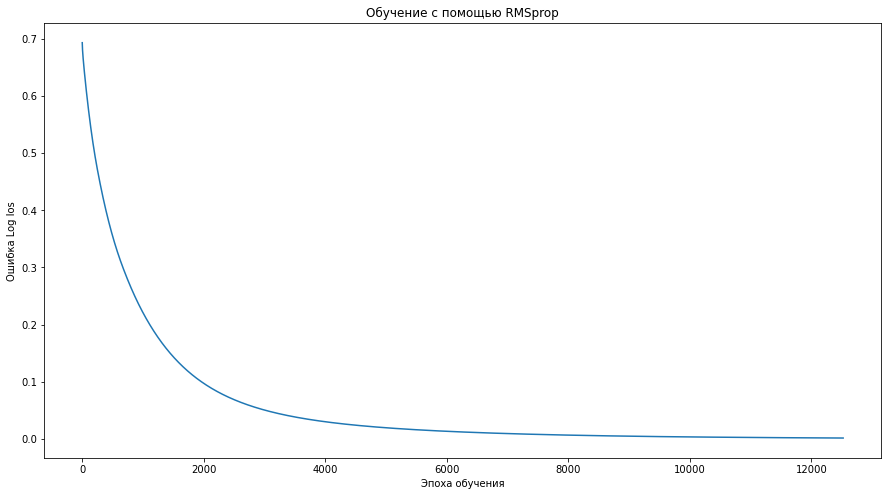

In [85]:
loss_RMSprop = model_RMSpro.costs_rms

# Постриом график, как изменялась ошибка в процессе обучения модели
plt.figure(figsize= (15, 8))
plt.plot(loss_RMSprop)
plt.title('Обучение с помощью RMSprop')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка Log los')
plt.show()

In [90]:
# Проверим метрику качества Accuracy на отложенной тестовой выборке:

y_pred_rms = model_RMSpro.predict(X_test)

score = (y_pred_rms == y_test).mean()
print(f'Метрика качества accuracy: {score}')

Метрика качества accuracy: 0.8333333333333334
